<h4 style="text-align: center;">Instituto Federal de Educação, Ciência e Tecnologia de Minas Gerais - IFMG<br>Especialização em Inteligência Artificial - EiA<br>Aprendizado de Máquina<br>Prof.: Frederico Gadelha Guimarães<br>Aluno: Fernando dos Santos Alves Fernandes</h4>

# Trabalho Prático

### Pipeline completo de aprendizado de máquina para os métodos *K-NN*, *Naive Bayes* e *Árvore de Decisão*, aplicado em duas bases de dados, para a tarefa de aprendizado supervisionado do tipo classificação.

In [1]:
import numpy as np
import pandas as pd
import warnings
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import scikitplot as skplt

warnings.filterwarnings('ignore')

### Base de dados Global Landslide Catalog (Fonte: https://www.kaggle.com/datasets/sathyanarayanrao89/global-landslide-catalog)

O Catálogo Global de Deslizamentos (GLC) é uma base de dados com eventos de deslizamentos desencadeados por chuvas do mundo todo e considera todos os tipos de movimentos de massa desencadeados por chuvas. Como informações principais, podem ser encontrados: a data do evento (*event_date*), o fator desencadeador (*landslide_trigger*), o tamanho do deslizamento (*landslide_size*), o número de vidas perdidas (*fatality_count*), o país em que o evento ocorreu (*country_name*), a descrição do local em que o evento ocorreu (*location_description*), entre outros atributos.
Para este trabalho, foram selecionados apenas dados do Brasil e os principais atributos de interesse.

A seguir, realiza-se o carregamento da base de dados GLC e um filtro é realizado, para obtenção dos dados relativos ao Brasil.

In [2]:
landslide_data1 = pd.read_csv('https://raw.githubusercontent.com/especializacao-ia-ifmg-op/mod_3_machine-learning/febad6167058cb15e2c99cb04cf9db7951f10c54/datasets/glc.csv')
df1_BR = landslide_data1.loc[landslide_data1['country_name'].str.contains('Brazil') == True, ['landslide_category', 'landslide_trigger', 'landslide_size', 'event_date', 'fatality_count', 'location_description', 'location_region']]
df1_BR

,landslide_category,landslide_trigger,landslide_size,event_date,fatality_count,location_description,location_region
307,landslide,other,medium,2013,6,"Santana, Amapá",AP
308,mudslide,downpour,medium,2013,16,"Lajedinho, Bahia",BA
309,landslide,downpour,medium,2015,7,"Travessa Moreira, Marotinho",BA
310,landslide,downpour,medium,2015,7,"Barro Branco, Av. San Antonio",BA
311,landslide,continuous_rain,small,2015,1,"Ladera da Montanha, Salvador",BA
...,...,...,...,...,...,...,...
516,mudslide,downpour,medium,2010,3,"Francisco Morato, Sao Paulo",SP
517,landslide,downpour,medium,2010,2,"Maua and Santo Andrea, Sao Paulo suburb",SP
518,landslide,rain,medium,2007,3,"Guaratingueta, northern Sao Paulo",SP
519,mudslide,downpour,large,2011,13,Sao Paolo,SP


In [3]:
df1_BR.describe()

,event_date,fatality_count
count,214.000000,214.000000
mean,2010.560748,8.144860
std,1.470700,41.975653
min,2007.000000,0.000000
25%,2010.000000,0.000000
50%,2010.000000,0.000000
75%,2011.000000,2.000000
max,2016.000000,424.000000


A seguir, são apresentados os estados do Brasil em que eventos de deslizamento foram registrados no GLC.

In [4]:
states_from_df1_BR = df1_BR['location_region'].unique()
states_from_df1_BR

array(['AP', 'BA', 'ES', 'MA', 'MG', 'PA', 'PR', 'PE', 'RJ', 'RN', 'RS',
       'SC', 'SP'], dtype=object)

Observa-se que foram registrados no Brasil deslizamentos entre os anos de 2007 e 2016. 

In [5]:
years_from_df1_BR = df1_BR['event_date'].unique()
years_from_df1_BR.sort()
years_from_df1_BR

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016],
      dtype=int64)

### Base de dados de precipitação (Fonte: https://www.kaggle.com/datasets/fabiopotsch/precipitation-in-brazil)

Uma vez que os dados da base GLC estão relacionados a eventos de deslizamentos desencadeados pela chuva, uma base de precipitação no Brasil foi utilizada. A base de precipitação do link acima, apresenta um conjunto de dados do nível de chuva no Brasil, dividido por estados, num período aproximado de 10 anos (1998 a 2017).

In [6]:
precipitation = pd.read_csv('https://raw.githubusercontent.com/especializacao-ia-ifmg-op/mod_3_machine-learning/febad6167058cb15e2c99cb04cf9db7951f10c54/datasets/precipitation.csv')
precipitation['year'] = pd.to_datetime(precipitation['date']).dt.year
precipitation

,state,date,precipitation,year
0,BA,31/01/1998,63.6,1998
1,BA,28/02/1998,55.6,1998
2,BA,31/03/1998,117.2,1998
3,BA,30/04/1998,206.0,1998
4,BA,31/05/1998,250.9,1998
...,...,...,...,...
5809,SC,31/07/2017,9.4,2017
5810,SC,31/08/2017,116.3,2017
5811,SC,30/09/2017,104.1,2017
5812,SC,31/10/2017,100.0,2017


*Observação*: Para facilitar a fusão dos dados de precipitação com os dados de deslizamentos, criou-se a coluna 'year', com o ano do registro de precipitação. Em seguida, filtrou-se a base de dados de precipitação, desconsiderando-se o atributo 'date'.

In [7]:
precip = precipitation[['state', 'precipitation', 'year']]
precip

,state,precipitation,year
0,BA,63.6,1998
1,BA,55.6,1998
2,BA,117.2,1998
3,BA,206.0,1998
4,BA,250.9,1998
...,...,...,...
5809,SC,9.4,2017
5810,SC,116.3,2017
5811,SC,104.1,2017
5812,SC,100.0,2017


A seguir, vemos todos os estados para os quais há informações sobre os níveis de chuva.

In [8]:
states_from_precip = precip['state'].unique()
states_from_precip

array(['BA', 'RR', 'SE', 'AL', 'TO', 'GO', 'PI', 'MG', 'PR', 'MA', 'AP',
       'RJ', 'AC', 'AM', 'DF', 'PE', 'CE', 'PA', 'MT', 'PB', 'RS', 'RN',
       'SP', 'ES', 'SC'], dtype=object)

*Obs.: * A base foi filtrada, de maneira que contemple apenas os estados para os quais se tem registros de deslizamentos.

In [9]:
years_from_precip = precip['year'].unique()
years_from_precip.sort()
years_from_precip

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

In [10]:
print(f'Dados de precipitação do período entre {years_from_df1_BR[0]} e {years_from_df1_BR[-1]}, para os estados: {states_from_df1_BR}')
filtered_precip = precip.loc[(precip['state'].isin(states_from_df1_BR))&(precip['year'].isin(years_from_df1_BR))]
filtered_precip

Dados de precipitação do período entre 2007 e 2016, para os estados: ['AP' 'BA' 'ES' 'MA' 'MG' 'PA' 'PR' 'PE' 'RJ' 'RN' 'RS' 'SC' 'SP']


,state,precipitation,year
108,BA,20.0,2007
109,BA,282.6,2007
110,BA,86.8,2007
111,BA,143.2,2007
112,BA,211.2,2007
...,...,...,...
5798,SC,77.6,2016
5799,SC,112.9,2016
5800,SC,177.9,2016
5801,SC,47.4,2016


### Agrupando os dados de precipitação para obter os totais por ano.

Para facilitar o trabalho de fusão das duas bases (*global-landslide-catalog* e *precipitation-in-brazil*), os dados de precipitação foram agrupados por estado e por ano, obtendo-se a precipitação anual total por estado.

In [11]:
gp = filtered_precip.groupby(by=['state', 'year'], as_index=False).sum()
gp

,state,year,precipitation
0,AP,2007,2695.3
1,AP,2008,2353.3
2,AP,2009,2508.0
3,AP,2010,2415.6
4,AP,2011,2557.7
...,...,...,...
125,SP,2012,1932.7
126,SP,2013,1391.3
127,SP,2014,1253.3
128,SP,2015,1896.8


Na célula a seguir, realiza-se a fusão das duas bases (*global-landslide-catalog* e *precipitation-in-brazil*).

In [12]:
merged_df = df1_BR.merge(gp, left_on='location_region', right_on='state')
merged_df

,landslide_category,landslide_trigger,landslide_size,event_date,fatality_count,location_description,location_region,state,year,precipitation
0,landslide,other,medium,2013,6,"Santana, Amapá",AP,AP,2007,2695.3
1,landslide,other,medium,2013,6,"Santana, Amapá",AP,AP,2008,2353.3
2,landslide,other,medium,2013,6,"Santana, Amapá",AP,AP,2009,2508.0
3,landslide,other,medium,2013,6,"Santana, Amapá",AP,AP,2010,2415.6
4,landslide,other,medium,2013,6,"Santana, Amapá",AP,AP,2011,2557.7
...,...,...,...,...,...,...,...,...,...,...
2135,mudslide,downpour,medium,2011,2,"Maua, Sao Paulo",SP,SP,2012,1932.7
2136,mudslide,downpour,medium,2011,2,"Maua, Sao Paulo",SP,SP,2013,1391.3
2137,mudslide,downpour,medium,2011,2,"Maua, Sao Paulo",SP,SP,2014,1253.3
2138,mudslide,downpour,medium,2011,2,"Maua, Sao Paulo",SP,SP,2015,1896.8


*Observação* : Após a fusão dos dados, têm-se dois atributos com a mesma informação ('location_region' e 'state'). Por isso, decide-se remover a coluna 'location_region'.

In [13]:
merged_df = merged_df.drop('location_region',axis=1)
merged_df

,landslide_category,landslide_trigger,landslide_size,event_date,fatality_count,location_description,state,year,precipitation
0,landslide,other,medium,2013,6,"Santana, Amapá",AP,2007,2695.3
1,landslide,other,medium,2013,6,"Santana, Amapá",AP,2008,2353.3
2,landslide,other,medium,2013,6,"Santana, Amapá",AP,2009,2508.0
3,landslide,other,medium,2013,6,"Santana, Amapá",AP,2010,2415.6
4,landslide,other,medium,2013,6,"Santana, Amapá",AP,2011,2557.7
...,...,...,...,...,...,...,...,...,...
2135,mudslide,downpour,medium,2011,2,"Maua, Sao Paulo",SP,2012,1932.7
2136,mudslide,downpour,medium,2011,2,"Maua, Sao Paulo",SP,2013,1391.3
2137,mudslide,downpour,medium,2011,2,"Maua, Sao Paulo",SP,2014,1253.3
2138,mudslide,downpour,medium,2011,2,"Maua, Sao Paulo",SP,2015,1896.8


#### Análise descritiva dos dados (Média, Máx., Mín.):

A seguir, segue uma análise exploratória e descritiva dos dados, a fim de se obter informações a respeito dos atributos e de suas relações.

In [14]:
merged_df.dropna(subset=['fatality_count'])

,landslide_category,landslide_trigger,landslide_size,event_date,fatality_count,location_description,state,year,precipitation
0,landslide,other,medium,2013,6,"Santana, Amapá",AP,2007,2695.3
1,landslide,other,medium,2013,6,"Santana, Amapá",AP,2008,2353.3
2,landslide,other,medium,2013,6,"Santana, Amapá",AP,2009,2508.0
3,landslide,other,medium,2013,6,"Santana, Amapá",AP,2010,2415.6
4,landslide,other,medium,2013,6,"Santana, Amapá",AP,2011,2557.7
...,...,...,...,...,...,...,...,...,...
2135,mudslide,downpour,medium,2011,2,"Maua, Sao Paulo",SP,2012,1932.7
2136,mudslide,downpour,medium,2011,2,"Maua, Sao Paulo",SP,2013,1391.3
2137,mudslide,downpour,medium,2011,2,"Maua, Sao Paulo",SP,2014,1253.3
2138,mudslide,downpour,medium,2011,2,"Maua, Sao Paulo",SP,2015,1896.8


In [15]:
merged_df['state'].describe()

count     2140
unique      13
top         RJ
freq      1600
Name: state, dtype: object

*Obs.: * Percebe-se que há registros de deslizamentos em apenas 13 dos 26 estados brasileiros. Tendo o Rio de Janeiro como o estado de maior ocorrência.

In [16]:
nan_proporttion = merged_df.isna().mean()
nan_proporttion

landslide_category      0.0
landslide_trigger       0.0
landslide_size          0.0
event_date              0.0
fatality_count          0.0
location_description    0.0
state                   0.0
year                    0.0
precipitation           0.0
dtype: float64

In [17]:
merged_df['landslide_size'].unique()

array(['medium', 'small', 'large', 'very_large'], dtype=object)

In [18]:
merged_df.describe()

,event_date,fatality_count,year,precipitation
count,2140.000000,2140.000000,2140.000000,2140.000000
mean,2010.560748,8.144860,2011.500000,1254.726822
std,1.467603,41.887252,2.872953,482.674830
min,2007.000000,0.000000,2007.000000,585.000000
25%,2010.000000,0.000000,2009.000000,904.800000
50%,2010.000000,0.000000,2011.500000,1208.000000
75%,2011.000000,2.000000,2014.000000,1525.300000
max,2016.000000,424.000000,2016.000000,3775.600000


Vamos utilizar o conjunto de dados para classificar o nível do deslizamento (*landslide_size*). Antes, realizamos uma última transformação dos atributos categóricos diferentes do atributo alvo.

In [19]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()

for col in merged_df.columns:
    if (col != 'landslide_size') and (merged_df[col].dtype == 'object'):
        merged_df[col] = le.fit_transform(merged_df[col].astype(str))

merged_df

,landslide_category,landslide_trigger,landslide_size,event_date,fatality_count,location_description,state,year,precipitation
0,1,3,medium,2013,6,160,0,2007,2695.3
1,1,3,medium,2013,6,160,0,2008,2353.3
2,1,3,medium,2013,6,160,0,2009,2508.0
3,1,3,medium,2013,6,160,0,2010,2415.6
4,1,3,medium,2013,6,160,0,2011,2557.7
...,...,...,...,...,...,...,...,...,...
2135,2,2,medium,2011,2,93,12,2012,1932.7
2136,2,2,medium,2011,2,93,12,2013,1391.3
2137,2,2,medium,2011,2,93,12,2014,1253.3
2138,2,2,medium,2011,2,93,12,2015,1896.8


O nível (tamanho, severidade) de um deslizamento pode ser classificado como *medium*, *small*, *large*, *very_large*, conforme os possíveis valores do atributo *landslide_size*.

In [20]:
merged_df['landslide_size'].unique()

array(['medium', 'small', 'large', 'very_large'], dtype=object)

A seguir, as principais informações estatísticas dos atributos númericos da base.

In [21]:
merged_df.describe()

,landslide_category,landslide_trigger,event_date,fatality_count,location_description,state,year,precipitation
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,1.261682,2.093458,2010.560748,8.144860,103.785047,7.808411,2011.500000,1254.726822
std,0.489945,0.634562,1.467603,41.887252,60.079662,2.090904,2.872953,482.674830
min,0.000000,0.000000,2007.000000,0.000000,0.000000,0.000000,2007.000000,585.000000
25%,1.000000,2.000000,2010.000000,0.000000,52.000000,8.000000,2009.000000,904.800000
50%,1.000000,2.000000,2010.000000,0.000000,104.500000,8.000000,2011.500000,1208.000000
75%,2.000000,2.000000,2011.000000,2.000000,156.000000,8.000000,2014.000000,1525.300000
max,3.000000,5.000000,2016.000000,424.000000,207.000000,12.000000,2016.000000,3775.600000


In [22]:
# Resumo das observações
print(f'|---------------------------------------------|')
print(f'|          Resumo das observações             |')
print(f'|---------------------------------------------|')
print(f'|Classes                | {len(merged_df["landslide_size"].unique())}                   |')
print(f'|---------------------------------------------|')
print(f'|Observações por Classe | {merged_df["landslide_size"].value_counts().unique()[0]}, {merged_df["landslide_size"].value_counts().unique()[1]}, {merged_df["landslide_size"].value_counts().unique()[2]}, {merged_df["landslide_size"].value_counts().unique()[3]}  |')
print(f'|---------------------------------------------|')
print(f'|Total observações      | {merged_df.shape[0]}                |')
print(f'|---------------------------------------------|')
print(f'|Dimensionalidade       | {merged_df.shape[1] - 1}                   |')
print(f'|---------------------------------------------|')

|---------------------------------------------|
|          Resumo das observações             |
|---------------------------------------------|
|Classes                | 4                   |
|---------------------------------------------|
|Observações por Classe | 1790, 160, 100, 90  |
|---------------------------------------------|
|Total observações      | 2140                |
|---------------------------------------------|
|Dimensionalidade       | 8                   |
|---------------------------------------------|


*Observação: * Percebe-se que o conjunto de dados é desbalanceado, em relação às classes, uma vez que a classe 'medium' ocorre com muito maior frequência do que as classes 'small', 'large' e 'very_large'.

### Avaliando os modelos de classificação: K-Nearest Neighbor, Naive Bayes e Decision Tree
Inicialmente, vamos criar pipelines e executá-los `N` vezes. Antes de treinar o modelo, vamos embaralhar a base (`random_state` = `None`, por default).

In [23]:
X = merged_df.drop('landslide_size',axis=1)
y = merged_df['landslide_size']

In [24]:
K = 3
N = 10
acuracias_knn = list()
knn_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("KNN", KNeighborsClassifier(n_neighbors=K))
])

for i in range(N):
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=True)
    knn_pipeline.fit(X_treino, y_treino)
    ac_i = knn_pipeline.score(X_teste, y_teste)
    acuracias_knn.append(ac_i)

print("- Acurácia [KNN]:")
print(f"Media: {round(np.mean(acuracias_knn) * 100, 2)}%")
print(f"Desvio padrão: {round(np.std(acuracias_knn) * 100, 2)}%")

- Acurácia [KNN]:
Media: 90.07%
Desvio padrão: 1.21%


In [25]:
acuracias_nb = list()
nb_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("NB", GaussianNB())
])

for i in range(N):
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=True)
    nb_pipeline.fit(X_treino, y_treino)
    ac_i = nb_pipeline.score(X_teste, y_teste)
    acuracias_nb.append(ac_i)

print("\n- Acurácia [NB]:")
print(f"Media: {round(np.mean(acuracias_nb) * 100, 2)}%")
print(f"Desvio padrão: {round(np.std(acuracias_nb) * 100, 2)}%")


- Acurácia [NB]:
Media: 85.7%
Desvio padrão: 1.58%


In [26]:
acuracias_dt = list()
dt_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("NB", DecisionTreeClassifier())
])

for i in range(N):
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=True)
    dt_pipeline.fit(X_treino, y_treino)
    ac_i = dt_pipeline.score(X_teste, y_teste)
    acuracias_dt.append(ac_i)

print("\n- Acurácia [DT]:")
print(f"Media: {round(np.mean(acuracias_dt) * 100, 2)}%")
print(f"Desvio padrão: {round(np.std(acuracias_dt) * 100, 2)}%")


- Acurácia [DT]:
Media: 99.16%
Desvio padrão: 0.36%


#### Utilizando `cross-validation`
Vamos utilizar a validação cruzada (*cross-validation*).

In [27]:
knn_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("KNN", KNeighborsClassifier(n_neighbors=3))
])

gnb_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("GNB", GaussianNB())
])

dt_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("DT", DecisionTreeClassifier())
])

#### Usando `cross_val_score`
Essa função, basicamente, executa o cross-validation de acordo com o número de *folders* informada via parâmetro `cv`. Na sequência ela retorna uma métrica de performance para cada folder de teste. Por padrão, essa métrica é a acurácia (para classificação), mas pode-se defini-la usando o parâmetro `scoring`.

In [28]:
acuracias_knn = cross_val_score(knn_pipeline, X, y, cv=5)
print("acuracias KNN:", acuracias_knn)
print("acuracia final KNN:", np.mean(acuracias_knn), "+-", np.std(acuracias_knn))

acuracias_nb = cross_val_score(gnb_pipeline, X, y, cv=5)
print("\nacuracias Naive Bayes:", acuracias_nb)
print("acuracia final Naive Bayes:", np.mean(acuracias_nb), "+-", np.std(acuracias_nb))

acuracias_dt = cross_val_score(dt_pipeline, X, y, cv=5)
print("\nacuracias Decision Tree:", acuracias_dt)
print("acuracia final Decision Tree:", np.mean(acuracias_dt), "+-", np.std(acuracias_dt))

acuracias KNN: [0.69626168 0.78738318 0.76869159 0.85981308 0.76635514]
acuracia final KNN: 0.7757009345794392 +- 0.05226547256721657

acuracias Naive Bayes: [0.53738318 0.85747664 0.12616822 0.89485981 0.80140187]
acuracia final Naive Bayes: 0.6434579439252336 +- 0.2873303651800073

acuracias Decision Tree: [0.76168224 0.85981308 0.78971963 0.8364486  0.74299065]
acuracia final Decision Tree: 0.7981308411214953 +- 0.04407411634598726


In [29]:
f1s_knn = cross_val_score(knn_pipeline, X, y, cv=5, scoring="f1_macro")
print("F1-macros KNN:", f1s_knn)
print("F1-macros KNN:", np.mean(f1s_knn), "+-", np.std(f1s_knn))

f1s_nb = cross_val_score(gnb_pipeline, X, y, cv=5, scoring="f1_macro")
print("\nF1-macros NB:", f1s_nb)
print("F1-macros NB:", np.mean(f1s_nb), "+-", np.std(f1s_nb))

f1s_dt = cross_val_score(dt_pipeline, X, y, cv=5, scoring="f1_macro")
print("\nF1-macros DT:", f1s_dt)
print("F1-macros NB:", np.mean(f1s_dt), "+-", np.std(f1s_dt))

F1-macros KNN: [0.20523416 0.37507185 0.50328612 0.32983531 0.41096834]
F1-macros KNN: 0.3648791561478777 +- 0.09808077090689386

F1-macros NB: [0.29656624 0.3870148  0.20976898 0.58435621 0.63762033]
F1-macros NB: 0.42306530864716085 +- 0.16422276792594703

F1-macros DT: [0.22858201 0.49820123 0.5248936  0.6014203  0.52789908]
F1-macros NB: 0.47619924366926114 +- 0.1284700039235334


#### Usando `cross_validate`
Com `cross_validate`, pode-se setar uma lista com as métricas desejadas. Além disso, esse método retorna o tempos de `fit` e de `score`.

In [30]:
nome_metricas = ['accuracy', 'precision_macro', 'recall_macro']
metricas_knn = cross_validate(knn_pipeline, X, y, cv=5, scoring=nome_metricas)
metricas_nb = cross_validate(gnb_pipeline, X, y, cv=5, scoring=nome_metricas)
metricas_dt = cross_validate(dt_pipeline, X, y, cv=5, scoring=nome_metricas)

print(f'KNN:')
for met in metricas_knn:
    print(f"- {met}:")
    print(f"-- {metricas_knn[met]}")
    print(f"-- {np.mean(metricas_knn[met])} +- {np.std(metricas_knn[met])}\n")

KNN:
- fit_time:
-- [0.00899911 0.0069983  0.00784397 0.0079875  0.00799918]
-- 0.007965612411499023 +- 0.0006356430587409109

- score_time:
-- [0.02999949 0.0199995  0.02175546 0.03299308 0.03700495]
-- 0.02835049629211426 +- 0.0065177589075002835

- test_accuracy:
-- [0.69626168 0.78738318 0.76869159 0.85981308 0.76635514]
-- 0.7757009345794392 +- 0.05226547256721657

- test_precision_macro:
-- [0.20244565 0.44054762 0.52973647 0.34436275 0.45259259]
-- 0.39393701522972624 +- 0.11241091289855595

- test_recall_macro:
-- [0.20810056 0.35004946 0.48555827 0.328125   0.42409606]
-- 0.3591858705772812 +- 0.09387048439538538



In [31]:
print(f'\nNB: ')
for met in metricas_nb:
    print(f"- {met}:")
    print(f"-- {metricas_nb[met]}")
    print(f"-- {np.mean(metricas_nb[met])} +- {np.std(metricas_nb[met])}\n") 


NB: 
- fit_time:
-- [0.00699043 0.00602555 0.00499821 0.00499916 0.0059936 ]
-- 0.0058013916015625 +- 0.0007469528199007819

- score_time:
-- [0.01298523 0.01097107 0.01000142 0.00800586 0.00700355]
-- 0.009793424606323242 +- 0.0021258668008190475

- test_accuracy:
-- [0.53738318 0.85747664 0.12616822 0.89485981 0.80140187]
-- 0.6434579439252336 +- 0.2873303651800073

- test_precision_macro:
-- [0.32628838 0.49134077 0.26747702 0.63405724 0.69397671]
-- 0.482628021456203 +- 0.16637729616921573

- test_recall_macro:
-- [0.3640014  0.35677083 0.34039417 0.57010397 0.73879869]
-- 0.4740138112973309 +- 0.15687396694376612



In [32]:
print(f'\nDT: ')
for met in metricas_dt:
    print(f"- {met}:")
    print(f"-- {metricas_dt[met]}")
    print(f"-- {np.mean(metricas_dt[met])} +- {np.std(metricas_dt[met])}\n") 


DT: 
- fit_time:
-- [0.00599813 0.00599408 0.00803113 0.00799847 0.00696659]
-- 0.0069976806640625 +- 0.0009029794722329516

- score_time:
-- [0.0090065  0.00699997 0.00700068 0.00800037 0.00703287]
-- 0.00760807991027832 +- 0.0007973789754401691

- test_accuracy:
-- [0.76168224 0.85981308 0.78971963 0.81308411 0.74299065]
-- 0.7934579439252337 +- 0.040887182905097845

- test_precision_macro:
-- [0.27454314 0.61652237 0.51834229 0.47970559 0.54078907]
-- 0.4859804914775025 +- 0.11474979486712869

- test_recall_macro:
-- [0.31302374 0.44787787 0.5588338  0.61265324 0.73402584]
-- 0.5332828988206082 +- 0.14356764413934936



### Predições com `cross_val_predict`
As predições serão obtidas para o conjunto de teste de cada uma das *folders*. Para `cv=5`, o modelo vai ser treinado para 4 partições e testado em 1 e, ao final das 5 execuções, os resultados são concatenados e retornados.


In [33]:
pred_knn = cross_val_predict(knn_pipeline, X, y, cv=5)
print(f'KNN: {pred_knn}')

pred_nb = cross_val_predict(gnb_pipeline, X, y, cv=5)
print(f'NB: {pred_nb}')

pred_dt = cross_val_predict(dt_pipeline, X, y, cv=5)
print(f'DT: {pred_dt}')

KNN: ['medium' 'medium' 'medium' ... 'medium' 'very_large' 'medium']
NB: ['medium' 'medium' 'medium' ... 'medium' 'medium' 'medium']
DT: ['medium' 'medium' 'medium' ... 'very_large' 'very_large' 'very_large']


Pode-se setar o parametro `method` para escolher qual predição será retornada.

In [34]:
pred_prob_knn = cross_val_predict(knn_pipeline, X, y, cv=5, method="predict_proba")
print(f'KNN: {pred_prob_knn[0]}')

pred_prob_nb = cross_val_predict(gnb_pipeline, X, y, cv=5, method="predict_proba")
print(f'NB: {pred_prob_nb[0]}')

pred_prob_dt = cross_val_predict(dt_pipeline, X, y, cv=5, method="predict_proba")
print(f'DT: {pred_prob_dt[0]}')

KNN: [0. 1. 0. 0.]
NB: [2.57675276e-05 9.99974024e-01 0.00000000e+00 2.08512569e-07]
DT: [0. 1. 0. 0.]


#### Utilizando `KFold` para criar as partições de treinamento e teste
`KFold` retorn um *generator* com os indices para selecionar os dados de acordo com o número de *folders* informadas.

In [35]:
n_folders = 5
cross_val = KFold(n_splits=n_folders, shuffle=True, random_state=32)
dados_cv = {f"folder_{f+1}": {"treino": None, "teste": None} for f in range(n_folders)}

#print(dados_cv)

k = 1

for indices_treino, indices_teste in cross_val.split(X):
    indices_treino = list(indices_treino)
    indices_teste = list(indices_teste)
    dados_cv[f"folder_{k}"]["treino"] = (X.iloc[indices_treino], y.iloc[indices_treino])
    dados_cv[f"folder_{k}"]["teste"] = (X.iloc[indices_teste], y.iloc[indices_teste])
    k+=1
print(dados_cv.keys())

dict_keys(['folder_1', 'folder_2', 'folder_3', 'folder_4', 'folder_5'])


As funções `cross_val_predict`, `cross_validate` e `cross_val_predict` aceitam que o parâmetro `cv` seja uma instancia da classe `KFold`. Isso garante que as partições sejam exatamente as mesmas.

In [36]:
pred_knn = cross_val_predict(knn_pipeline, X, y, cv=cross_val)
pred_prob_knn = cross_val_predict(knn_pipeline, X, y, cv=cross_val, method="predict_proba")
print(f'K-Nearest Neighbors:')
print(f'  {pred_knn[112]}')
print(f'  {pred_prob_knn[112]}')

pred_nb = cross_val_predict(gnb_pipeline, X, y, cv=cross_val)
pred_prob_nb = cross_val_predict(gnb_pipeline, X, y, cv=cross_val, method="predict_proba")
print(f'Naive Bayes:')
print(f'  {pred_nb[112]}')
print(f'  {pred_prob_nb[112]}')

pred_dt = cross_val_predict(dt_pipeline, X, y, cv=cross_val)
pred_prob_dt = cross_val_predict(dt_pipeline, X, y, cv=cross_val, method="predict_proba")
print(f'Decision Tree:')
print(f'  {pred_dt[112]}')
print(f'  {pred_prob_dt[112]}')

K-Nearest Neighbors:
  medium
  [0. 1. 0. 0.]
Naive Bayes:
  medium
  [7.57924276e-04 9.99223118e-01 1.59334296e-20 1.89573479e-05]
Decision Tree:
  medium
  [0. 1. 0. 0.]


In [37]:
acuracias_knn = list()

print(f'KNN:')
for folder in dados_cv:       
    knn_pipeline.fit(dados_cv[folder]["treino"][0], dados_cv[folder]["treino"][1])
    ac_i = knn_pipeline.score(dados_cv[folder]["teste"][0], dados_cv[folder]["teste"][1])
    acuracias_knn.append(ac_i)
    print(f"\t{folder}: {ac_i}")

print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_knn) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_knn) * 100, 2)}%\n")

print(f'NB:')
acuracias_nb = list()
for folder in dados_cv:       
    gnb_pipeline.fit(dados_cv[folder]["treino"][0], dados_cv[folder]["treino"][1])
    ac_i = gnb_pipeline.score(dados_cv[folder]["teste"][0], dados_cv[folder]["teste"][1])
    acuracias_nb.append(ac_i)
    print(f"\t{folder}: {ac_i}")

print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_nb) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_nb) * 100, 2)}%")

print(f'DT:')
acuracias_dt = list()
for folder in dados_cv:       
    dt_pipeline.fit(dados_cv[folder]["treino"][0], dados_cv[folder]["treino"][1])
    ac_i = dt_pipeline.score(dados_cv[folder]["teste"][0], dados_cv[folder]["teste"][1])
    acuracias_dt.append(ac_i)
    print(f"\t{folder}: {ac_i}")

print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_dt) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_dt) * 100, 2)}%")


KNN:
	folder_1: 0.8855140186915887
	folder_2: 0.8925233644859814
	folder_3: 0.9158878504672897
	folder_4: 0.8785046728971962
	folder_5: 0.8901869158878505

	Acurácia das folders:
	  Media: 89.25%
	  Desvio padrão: 1.26%

NB:
	folder_1: 0.8364485981308412
	folder_2: 0.8714953271028038
	folder_3: 0.8481308411214953
	folder_4: 0.8457943925233645
	folder_5: 0.8481308411214953

	Acurácia das folders:
	  Media: 85.0%
	  Desvio padrão: 1.16%
DT:
	folder_1: 0.9906542056074766
	folder_2: 0.9953271028037384
	folder_3: 0.9906542056074766
	folder_4: 0.9929906542056075
	folder_5: 0.9813084112149533

	Acurácia das folders:
	  Media: 99.02%
	  Desvio padrão: 0.48%


 #### Utilizando `StratifiedKFold` para criar as partições de treinamento e teste
A principal diferença em relação ao `KFold` é que o `StratifiedKFold` estratifica os dados de acordo com as classes. Em outras palavras, ele balanceia a quantidade de amostras de cada classe entre as *folders*.

In [38]:
n_folders = 5
cross_val_strat = StratifiedKFold(n_splits=n_folders, shuffle=True, random_state=32)
dados_cv_strat = {f"folder_{f+1}": {"treino": None, "teste": None} for f in range(n_folders)}
k = 1
for indices_treino, indices_teste in cross_val_strat.split(X, y):
    indices_treino = list(indices_treino)
    indices_teste = list(indices_teste)
    dados_cv_strat[f"folder_{k}"]["treino"] = (X.iloc[indices_treino], y.iloc[indices_treino])
    dados_cv_strat[f"folder_{k}"]["teste"] = (X.iloc[indices_teste], y.iloc[indices_teste])
    k+=1
print(dados_cv_strat.keys())

dict_keys(['folder_1', 'folder_2', 'folder_3', 'folder_4', 'folder_5'])


In [39]:
pred_knn = cross_val_predict(knn_pipeline, X, y, cv=cross_val_strat)
pred_prob_knn = cross_val_predict(knn_pipeline, X, y, cv=cross_val_strat, method="predict_proba")
print(f'K-Nearest Neighbors:')
print(f'  {pred_knn[112]}')
print(f'  {pred_prob_knn[112]}')

pred_nb = cross_val_predict(gnb_pipeline, X, y, cv=cross_val_strat)
pred_prob_nb = cross_val_predict(gnb_pipeline, X, y, cv=cross_val_strat, method="predict_proba")
print(f'Naive Bayes:')
print(f'  {pred_nb[112]}')
print(f'  {pred_prob_nb[112]}')

pred_dt = cross_val_predict(dt_pipeline, X, y, cv=cross_val_strat)
pred_prob_dt = cross_val_predict(dt_pipeline, X, y, cv=cross_val_strat, method="predict_proba")
print(f'Decision Tree:')
print(f'  {pred_dt[112]}')
print(f'  {pred_prob_dt[112]}')

K-Nearest Neighbors:
  medium
  [0. 1. 0. 0.]
Naive Bayes:
  medium
  [1.02375827e-03 9.98968125e-01 4.55557678e-25 8.11708458e-06]
Decision Tree:
  medium
  [0. 1. 0. 0.]


In [40]:
acuracias_knn = list()

print(f'KNN:')
for folder in dados_cv_strat:       
    knn_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    ac_i = knn_pipeline.score(dados_cv_strat[folder]["teste"][0], dados_cv_strat[folder]["teste"][1])
    acuracias_knn.append(ac_i)
    print(f"\t{folder}: {ac_i}")

print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_knn) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_knn) * 100, 2)}%\n")

print(f'NB:')
acuracias_nb = list()
for folder in dados_cv_strat:       
    gnb_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    ac_i = gnb_pipeline.score(dados_cv_strat[folder]["teste"][0], dados_cv_strat[folder]["teste"][1])
    acuracias_nb.append(ac_i)
    print(f"\t{folder}: {ac_i}")

print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_nb) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_nb) * 100, 2)}%")

print(f'DT:')
acuracias_dt = list()
for folder in dados_cv_strat:
    dt_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    ac_i = dt_pipeline.score(dados_cv_strat[folder]["teste"][0], dados_cv_strat[folder]["teste"][1])
    acuracias_dt.append(ac_i)
    print(f"\t{folder}: {ac_i}")

print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_dt) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_dt) * 100, 2)}%")

KNN:
	folder_1: 0.8785046728971962
	folder_2: 0.8808411214953271
	folder_3: 0.8878504672897196
	folder_4: 0.9135514018691588
	folder_5: 0.8785046728971962

	Acurácia das folders:
	  Media: 88.79%
	  Desvio padrão: 1.33%

NB:
	folder_1: 0.8434579439252337
	folder_2: 0.8574766355140186
	folder_3: 0.8317757009345794
	folder_4: 0.8574766355140186
	folder_5: 0.8855140186915887

	Acurácia das folders:
	  Media: 85.51%
	  Desvio padrão: 1.8%
DT:
	folder_1: 0.9906542056074766
	folder_2: 0.9929906542056075
	folder_3: 0.9883177570093458
	folder_4: 0.9906542056074766
	folder_5: 0.9906542056074766

	Acurácia das folders:
	  Media: 99.07%
	  Desvio padrão: 0.15%


### Ajustando hiperparâmetros dos modelos de classificação

In [41]:
from sklearn.model_selection import GridSearchCV

#### Ajuste do `KNeighborsClassifier`

In [42]:
param_grid = {'n_neighbors':[3,4,5],
              'weights':['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],      
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='f1_macro')
grid.fit(X,y)
grid.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}

#### Ajuste do `GaussianNB`

In [43]:
#{'var_smoothing': np.logspace(0,-9, num=100)}
#priors': [None],
param_grid = {'priors': [None],
              'var_smoothing': np.logspace(0,-9, num=100),
}


grid = GridSearchCV(GaussianNB(), param_grid, cv=10, scoring='f1_macro')
grid.fit(X,y)
grid.best_params_

{'priors': None, 'var_smoothing': 6.579332246575682e-07}

#### Ajuste do `DecisionTreeClassifier`

In [44]:
param_grid = {'criterion': ['gini','entropy','log_loss'],
              'max_depth': [2,3,4,5,6,7,8,9,10],
              'splitter': ['best', 'random']
}

grid = GridSearchCV(DecisionTreeClassifier(),param_grid,cv=10,scoring='f1_macro')
grid.fit(X,y)
grid.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'splitter': 'random'}

### Testando os modelos de classificação ajustados.

In [45]:
# {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}
knn_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("KNN", KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3, weights='distance'))
])

# {'priors': None, 'var_smoothing': 6.579332246575682e-07}
gnb_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("GNB", GaussianNB(priors=None, var_smoothing=6.5793))
])

# {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
dt_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("DT", DecisionTreeClassifier(criterion='gini', max_depth=10, splitter='best'))
])

In [46]:
n_folders = 5
cross_val_strat = StratifiedKFold(n_splits=n_folders, shuffle=True, random_state=32)
dados_cv_strat = {f"folder_{f+1}": {"treino": None, "teste": None} for f in range(n_folders)}
k = 1
for indices_treino, indices_teste in cross_val_strat.split(X, y):
    indices_treino = list(indices_treino)
    indices_teste = list(indices_teste)
    dados_cv_strat[f"folder_{k}"]["treino"] = (X.iloc[indices_treino], y.iloc[indices_treino])
    dados_cv_strat[f"folder_{k}"]["teste"] = (X.iloc[indices_teste], y.iloc[indices_teste])
    k+=1
print(dados_cv_strat.keys())

dict_keys(['folder_1', 'folder_2', 'folder_3', 'folder_4', 'folder_5'])


In [47]:
pred_knn = cross_val_predict(knn_pipeline, X, y, cv=cross_val_strat)
pred_prob_knn = cross_val_predict(knn_pipeline, X, y, cv=cross_val_strat, method="predict_proba")
print(f'K-Nearest Neighbors:')
print(f'  {pred_knn[112]}')
print(f'  {pred_prob_knn[112]}')

pred_nb = cross_val_predict(gnb_pipeline, X, y, cv=cross_val_strat)
pred_prob_nb = cross_val_predict(gnb_pipeline, X, y, cv=cross_val_strat, method="predict_proba")
print(f'Naive Bayes:')
print(f'  {pred_nb[112]}')
print(f'  {pred_prob_nb[112]}')

pred_dt = cross_val_predict(dt_pipeline, X, y, cv=cross_val_strat)
pred_prob_dt = cross_val_predict(dt_pipeline, X, y, cv=cross_val_strat, method="predict_proba")
print(f'Decision Tree:')
print(f'  {pred_dt[112]}')
print(f'  {pred_prob_dt[112]}')

K-Nearest Neighbors:
  medium
  [0. 1. 0. 0.]
Naive Bayes:
  medium
  [0.07429705 0.85251034 0.04194825 0.03124437]
Decision Tree:
  medium
  [0. 1. 0. 0.]


In [48]:
acuracias_knn = list()

print(f'KNN:')
for folder in dados_cv_strat:       
    knn_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    ac_i = knn_pipeline.score(dados_cv_strat[folder]["teste"][0], dados_cv_strat[folder]["teste"][1])
    acuracias_knn.append(ac_i)
    print(f"\t{folder}: {ac_i}")

print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_knn) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_knn) * 100, 2)}%\n")

print(f'NB:')
acuracias_nb = list()
for folder in dados_cv_strat:       
    gnb_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    ac_i = gnb_pipeline.score(dados_cv_strat[folder]["teste"][0], dados_cv_strat[folder]["teste"][1])
    acuracias_nb.append(ac_i)
    print(f"\t{folder}: {ac_i}")
print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_nb) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_nb) * 100, 2)}%")

print(f'DT:')
acuracias_dt = list()
for folder in dados_cv_strat:
    dt_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    ac_i = dt_pipeline.score(dados_cv_strat[folder]["teste"][0], dados_cv_strat[folder]["teste"][1])
    acuracias_dt.append(ac_i)
    print(f"\t{folder}: {ac_i}")

print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_dt) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_dt) * 100, 2)}%")

KNN:
	folder_1: 0.8691588785046729
	folder_2: 0.8691588785046729
	folder_3: 0.8808411214953271
	folder_4: 0.9042056074766355
	folder_5: 0.8621495327102804

	Acurácia das folders:
	  Media: 87.71%
	  Desvio padrão: 1.48%

NB:
	folder_1: 0.8364485981308412
	folder_2: 0.8364485981308412
	folder_3: 0.8364485981308412
	folder_4: 0.8364485981308412
	folder_5: 0.8364485981308412

	Acurácia das folders:
	  Media: 83.64%
	  Desvio padrão: 0.0%
DT:
	folder_1: 0.9813084112149533
	folder_2: 0.9789719626168224
	folder_3: 0.9976635514018691
	folder_4: 0.9953271028037384
	folder_5: 0.985981308411215

	Acurácia das folders:
	  Media: 98.79%
	  Desvio padrão: 0.74%


#### Plotando as `matrizes de confusão` para cada partição.

KNN:


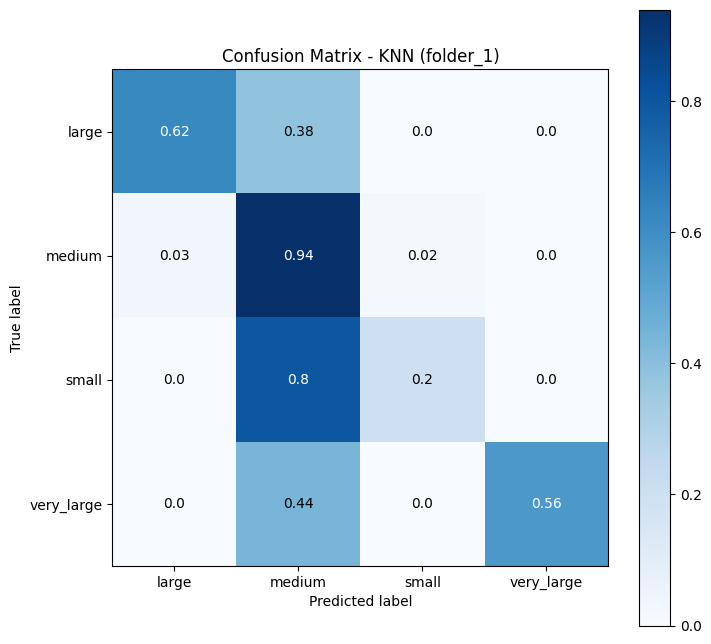

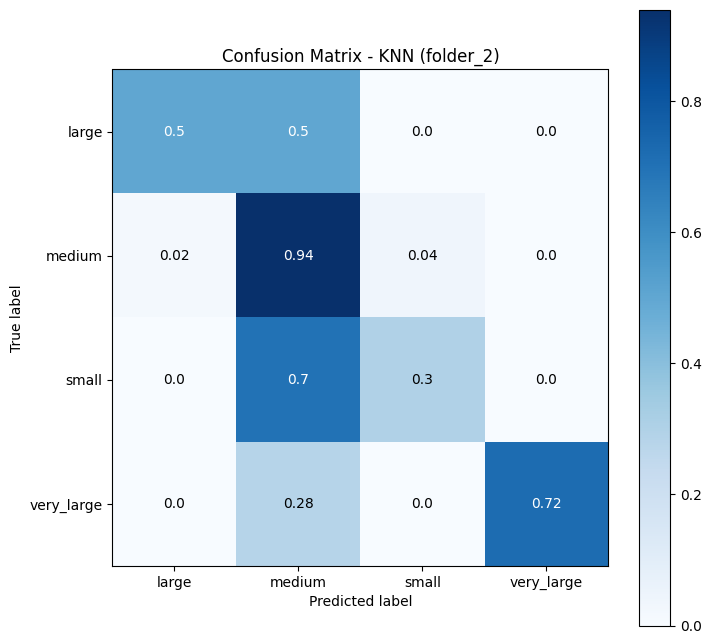

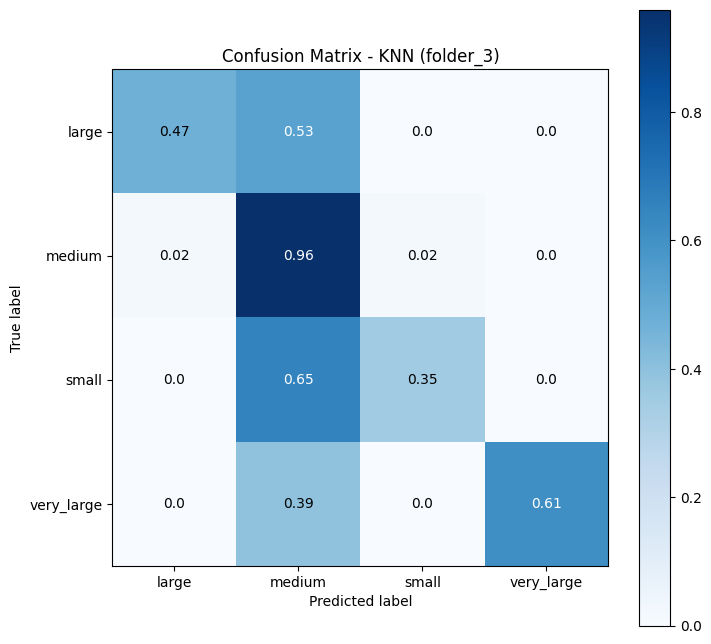

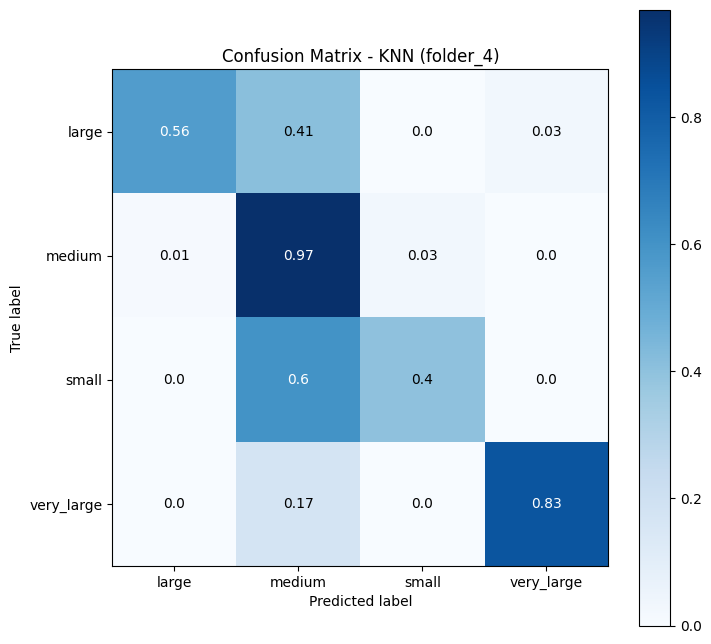

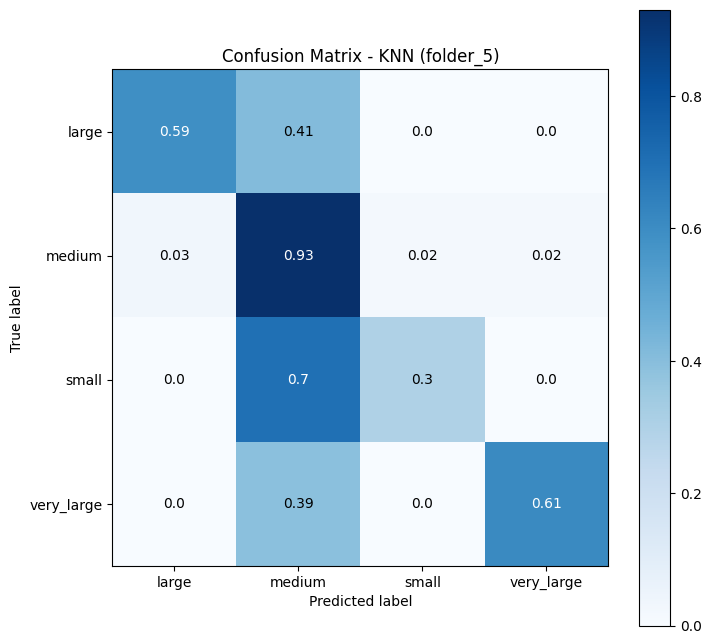

In [49]:
print(f'KNN:')
for folder in dados_cv_strat:       
    fig = plt.figure(figsize=(8,8))
    knn_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    Y_test = dados_cv_strat[folder]["teste"][1]
    Y_preds = knn_pipeline.predict(dados_cv_strat[folder]["teste"][0])
    ax = fig.add_subplot(111)
    
    skplt.metrics.plot_confusion_matrix(Y_test, Y_preds,
                                        normalize=True,
                                        title="Confusion Matrix - KNN (" + folder + ")",
                                        cmap="Blues",
                                        ax=ax
    );

NB:


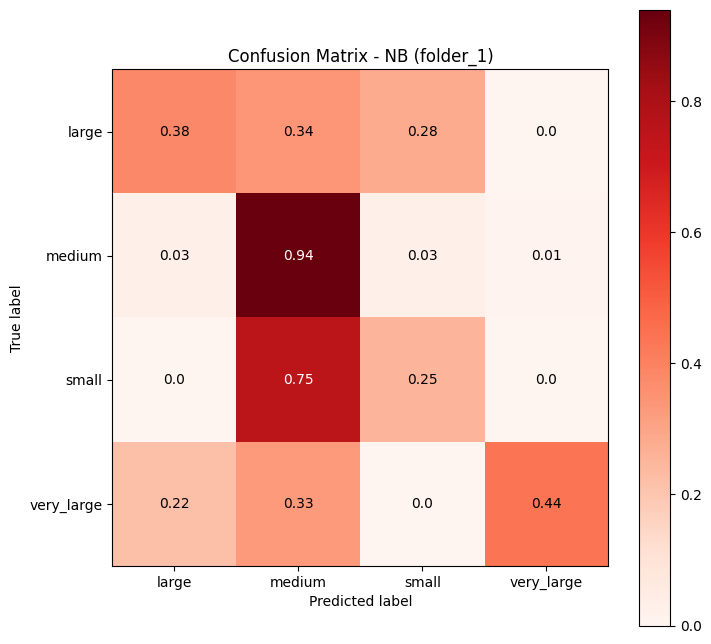

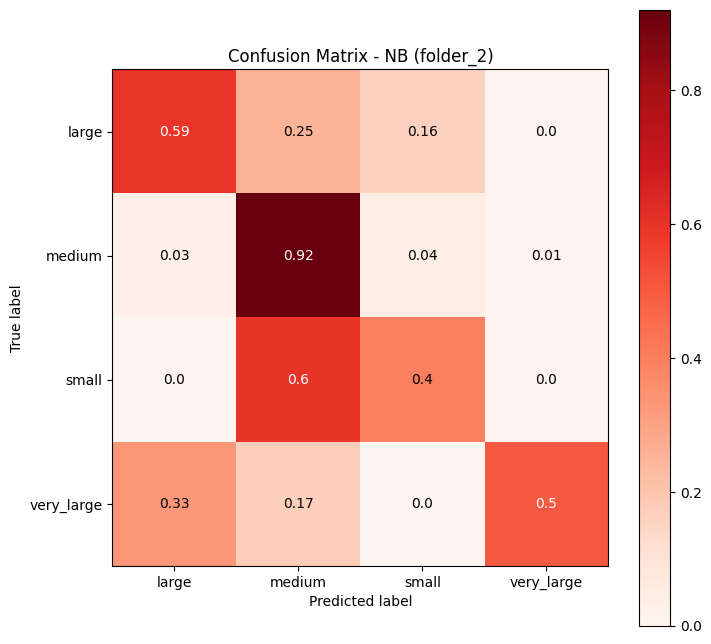

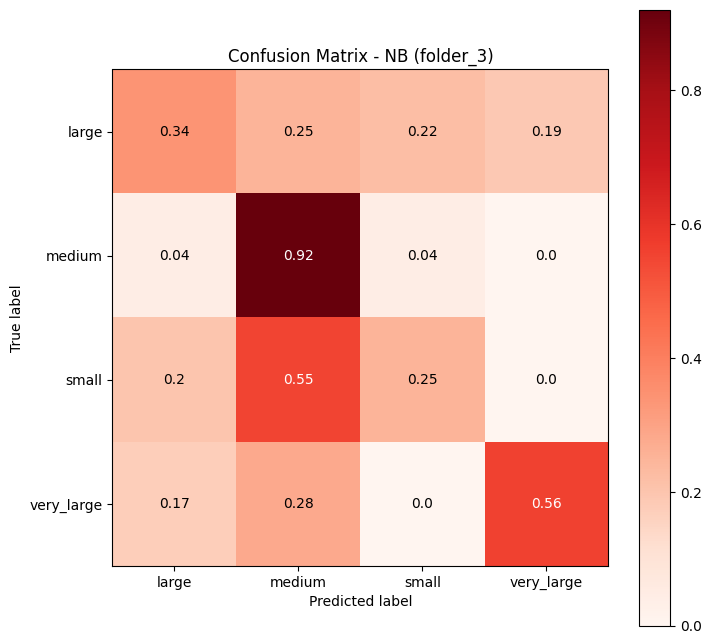

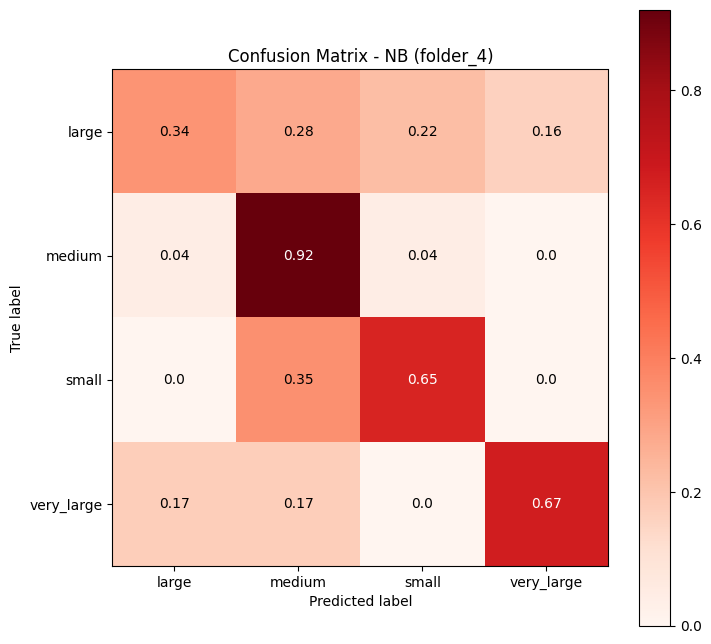

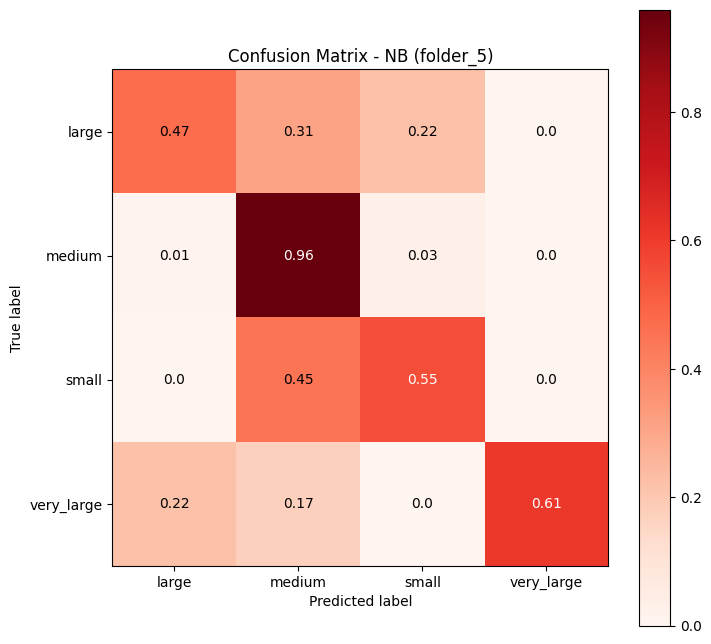

In [50]:
print(f'NB:')
for folder in dados_cv_strat:       
    fig = plt.figure(figsize=(8,8))
    nb_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    Y_test = dados_cv_strat[folder]["teste"][1]
    Y_preds = nb_pipeline.predict(dados_cv_strat[folder]["teste"][0])
    ax = fig.add_subplot(111)
    
    skplt.metrics.plot_confusion_matrix(Y_test, Y_preds,
                                        normalize=True,
                                        title="Confusion Matrix - NB (" + folder + ")",
                                        cmap="Reds",
                                        ax=ax
    );

DT:


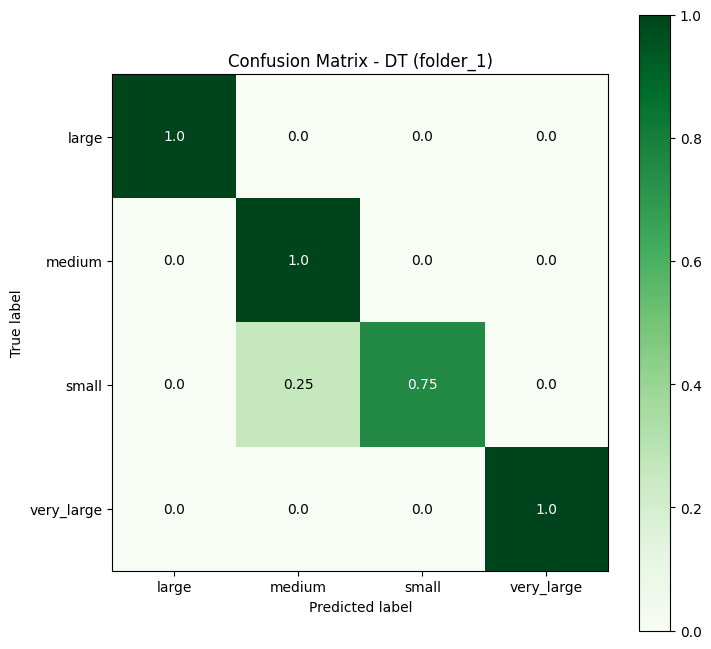

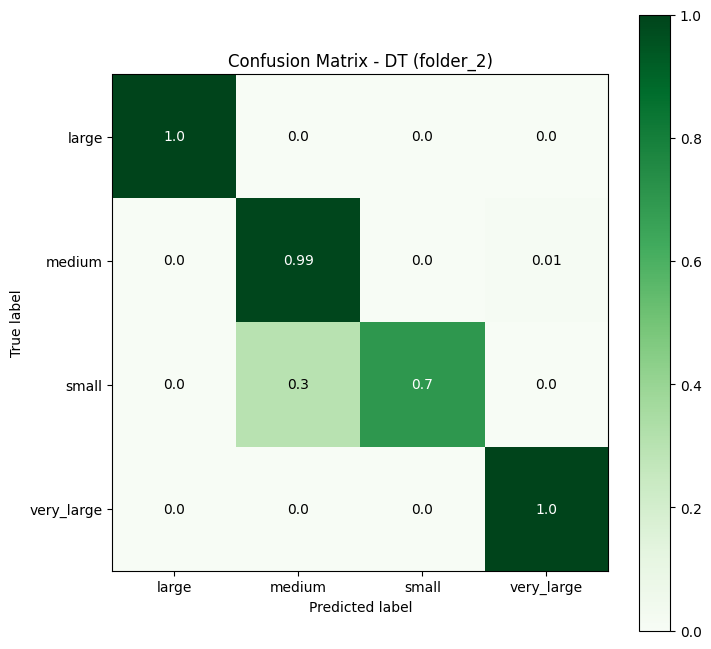

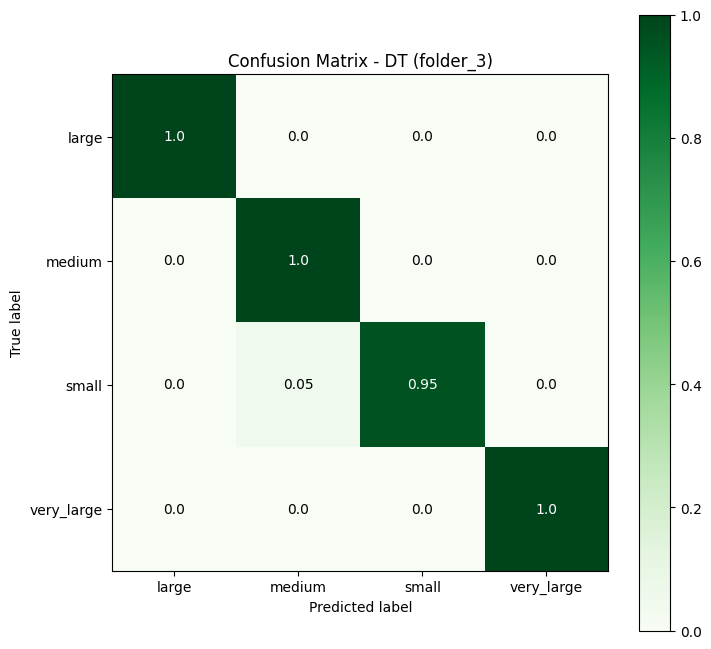

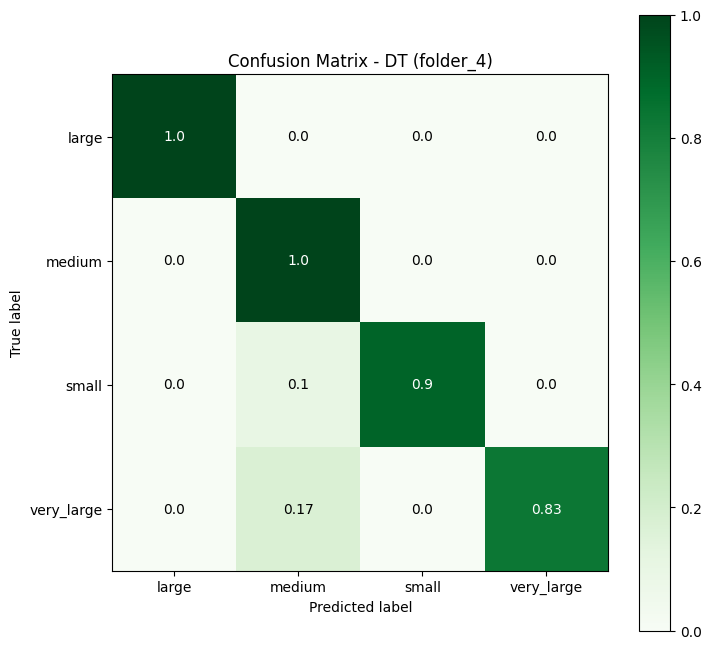

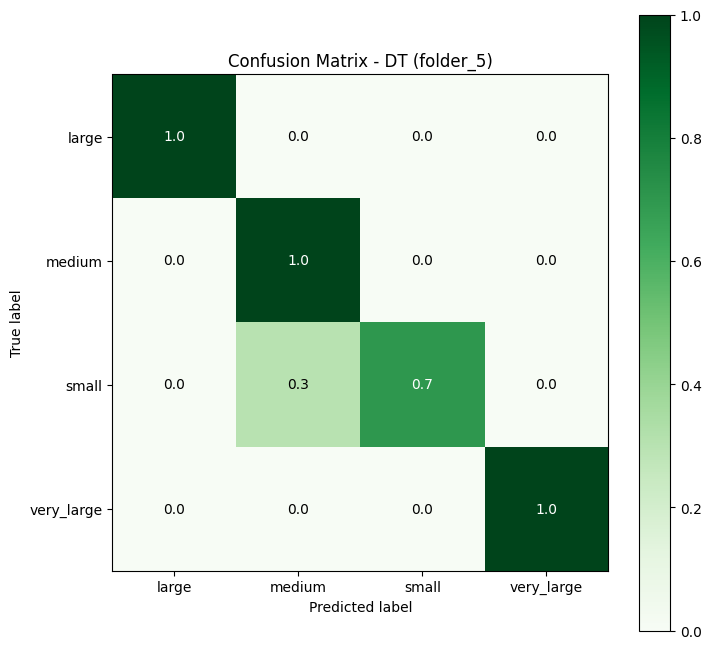

In [51]:
print(f'DT:')
for folder in dados_cv_strat:       
    fig = plt.figure(figsize=(8,8))
    dt_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    Y_test = dados_cv_strat[folder]["teste"][1]
    Y_preds = dt_pipeline.predict(dados_cv_strat[folder]["teste"][0])
    ax = fig.add_subplot(111)
    
    skplt.metrics.plot_confusion_matrix(Y_test, Y_preds,
                                        normalize=True,
                                        title="Confusion Matrix - DT (" + folder + ")",
                                        cmap="Greens",
                                        ax=ax
    );

### Base de dados Land Mines ([https://archive-beta.ics.uci.edu/dataset/763/land+mines-1](https://archive-beta.ics.uci.edu/dataset/763/land+mines-1))

A detecção de minas terrestres é muito importante em termos de segurança de pessoas e bens e o processo de detecção de minas consiste nas fases de: design do sensor, análise de dados e algoritmo de decisão. O método de anomalia magnética funciona de acordo com o princípio de medir as anomalias resultantes do objeto no campo magnético que perturba a estrutura do mesmo, o campo magnético, e os dados obtidos neste ponto são usados para determinar as condições como movimento e posição . A determinação de parâmetros como posição, profundidade ou direção do movimento usando anomalia magnética é realizada desde 1970.

Nessa base de dados, os atributos de entrada são: a tensão de saída do sensor, _Voltage (V)_; a altura do sensor, em relação ao solo, _High_ (H); e 6 diferentes tipos de solo, dependendo da condição de umidade, _Soil Type (S)_. O atributo alvo (_Mine Type (M)_), correspondente às classes de interesse é composto pelos 5 diferentes tipos de minas comumente encontradas no solo: 1 = _Null_, 2 = _Anti-Tank_, 3 = _Anti-personnel_, 4 = _Booby Trapped Anti-personnel_ e 5 = _M14 Anti-personnel_.

In [52]:
mine = pd.read_csv('https://raw.githubusercontent.com/especializacao-ia-ifmg-op/mod_3_machine-learning/main/datasets/land_mines.csv', sep=';')
mine

,V,H,S,M
0,0.338157,0.000000,0.0,1
1,0.320241,0.181818,0.0,1
2,0.287009,0.272727,0.0,1
3,0.256284,0.454545,0.0,1
4,0.262840,0.545455,0.0,1
...,...,...,...,...
333,0.323262,0.909091,0.4,5
334,0.444108,0.181818,1.0,5
335,0.353474,0.454545,1.0,5
336,0.362537,0.727273,1.0,5


In [53]:
mine.describe()

,V,H,S,M
count,338.000000,338.000000,338.000000,338.000000
mean,0.430634,0.508876,0.503550,2.952663
std,0.195819,0.306043,0.344244,1.419703
min,0.197734,0.000000,0.000000,1.000000
25%,0.309737,0.272727,0.200000,2.000000
50%,0.359516,0.545455,0.600000,3.000000
75%,0.482628,0.727273,0.800000,4.000000
max,0.999999,1.000000,1.000000,5.000000


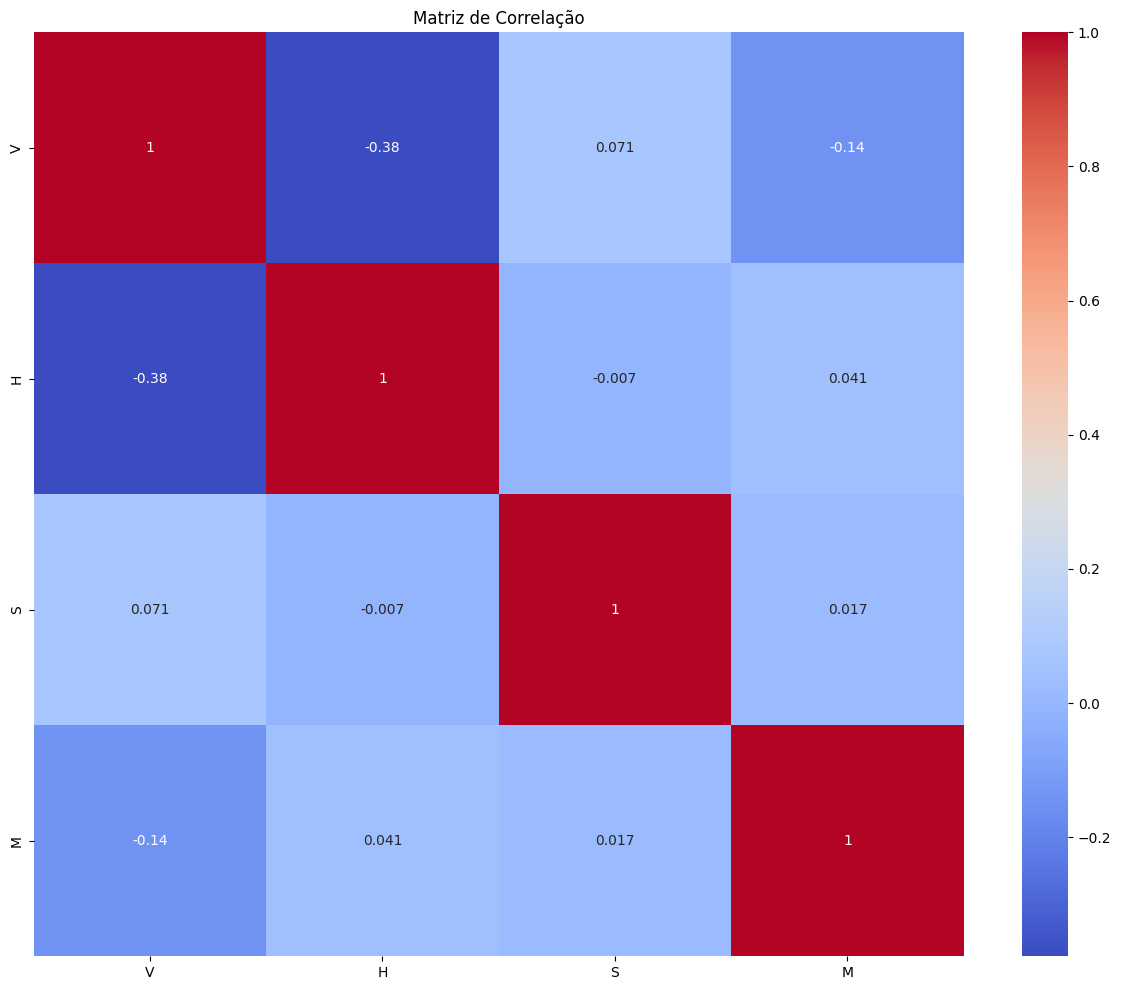

In [54]:
#Correlação dos dados 
plt.figure(figsize=(15, 12))
correlation_matrix = mine.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

### Avaliando os modelos de classificação: K-Nearest Neighbor, Naive Bayes e Decision Tree

In [55]:
n_neighbors = 3

X = mine.drop('M', axis=1)
X = X.iloc[:,:2]
y = mine['M']

#### Executando `N` vezes

In [56]:
K = 3
N = 10
acuracias_knn = list()
knn_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("KNN", KNeighborsClassifier(n_neighbors=K))
])

for i in range(N):
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=True)
    knn_pipeline.fit(X_treino, y_treino)
    ac_i = knn_pipeline.score(X_teste, y_teste)
    acuracias_knn.append(ac_i)

print("- Acurácia [KNN]:")
print(f"Media: {round(np.mean(acuracias_knn) * 100, 2)}%")
print(f"Desvio padrão: {round(np.std(acuracias_knn) * 100, 2)}%")

- Acurácia [KNN]:
Media: 42.79%
Desvio padrão: 4.85%


In [57]:
acuracias_nb = list()
nb_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("NB", GaussianNB())
])

for i in range(N):
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=True)
    nb_pipeline.fit(X_treino, y_treino)
    ac_i = nb_pipeline.score(X_teste, y_teste)
    acuracias_nb.append(ac_i)

print("\n- Acurácia [NB]:")
print(f"Media: {round(np.mean(acuracias_nb) * 100, 2)}%")
print(f"Desvio padrão: {round(np.std(acuracias_nb) * 100, 2)}%")


- Acurácia [NB]:
Media: 46.76%
Desvio padrão: 7.89%


In [58]:
acuracias_dt = list()
dt_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("NB", DecisionTreeClassifier())
])

for i in range(N):
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=True)
    dt_pipeline.fit(X_treino, y_treino)
    ac_i = dt_pipeline.score(X_teste, y_teste)
    acuracias_dt.append(ac_i)

print("\n- Acurácia [DT]:")
print(f"Media: {round(np.mean(acuracias_dt) * 100, 2)}%")
print(f"Desvio padrão: {round(np.std(acuracias_dt) * 100, 2)}%")


- Acurácia [DT]:
Media: 44.71%
Desvio padrão: 2.48%


#### Utilizando `cross-validation`

In [59]:
knn_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("KNN", KNeighborsClassifier(n_neighbors=3))
])

gnb_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("GNB", GaussianNB())
])

dt_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("DT", DecisionTreeClassifier())
])

In [60]:
nome_metricas = ['accuracy', 'precision_macro', 'recall_macro']
metricas_knn = cross_validate(knn_pipeline, X, y, cv=5, scoring=nome_metricas)
metricas_nb = cross_validate(gnb_pipeline, X, y, cv=5, scoring=nome_metricas)
metricas_dt = cross_validate(dt_pipeline, X, y, cv=5, scoring=nome_metricas)

print(f'KNN:')
for met in metricas_knn:
    print(f"- {met}:")
    print(f"-- {metricas_knn[met]}")
    print(f"-- {np.mean(metricas_knn[met])} +- {np.std(metricas_knn[met])}\n")

KNN:
- fit_time:
-- [0.00999689 0.0039947  0.00300217 0.00300026 0.00299978]
-- 0.004598760604858398 +- 0.00272638023987387

- score_time:
-- [0.00999618 0.00599957 0.00799775 0.00500035 0.00600004]
-- 0.006998777389526367 +- 0.0017872853147010653

- test_accuracy:
-- [0.42647059 0.35294118 0.41176471 0.47761194 0.43283582]
-- 0.420324846356453 +- 0.040224223377730677

- test_precision_macro:
-- [0.30100218 0.33833333 0.32807018 0.36126496 0.3754755 ]
-- 0.3408292299146788 +- 0.02597383416124694

- test_recall_macro:
-- [0.40410256 0.34505495 0.40549451 0.46373626 0.41978022]
-- 0.40763369963369966 +- 0.03802152349626338



In [61]:
print(f'\nNB: ')
for met in metricas_nb:
    print(f"- {met}:")
    print(f"-- {metricas_nb[met]}")
    print(f"-- {np.mean(metricas_nb[met])} +- {np.std(metricas_nb[met])}\n") 


NB: 
- fit_time:
-- [0.00300288 0.00203204 0.00299358 0.00399995 0.00200057]
-- 0.002805805206298828 +- 0.0007412410786968695

- score_time:
-- [0.00599957 0.00399995 0.00300646 0.00300002 0.00403118]
-- 0.0040074348449707035 +- 0.0010941699835161532

- test_accuracy:
-- [0.35294118 0.48529412 0.47058824 0.40298507 0.53731343]
-- 0.44982440737489027 +- 0.06468979826138076

- test_precision_macro:
-- [0.26909091 0.505      0.43222661 0.32777778 0.57962963]
-- 0.4227449860928122 +- 0.11322272386064965

- test_recall_macro:
-- [0.33142857 0.48241758 0.46373626 0.39340659 0.52857143]
-- 0.4399120879120879 +- 0.06952153834724438



In [62]:
print(f'\nDT: ')
for met in metricas_dt:
    print(f"- {met}:")
    print(f"-- {metricas_dt[met]}")
    print(f"-- {np.mean(metricas_dt[met])} +- {np.std(metricas_dt[met])}\n") 


DT: 
- fit_time:
-- [0.0069983  0.00303245 0.00399852 0.00299859 0.00299978]
-- 0.004005527496337891 +- 0.0015446082043782537

- score_time:
-- [0.00500059 0.00596786 0.00400019 0.00599957 0.00400257]
-- 0.00499415397644043 +- 0.0008865883689654596

- test_accuracy:
-- [0.55882353 0.41176471 0.42647059 0.50746269 0.47761194]
-- 0.4764266900790167 +- 0.053722735112411726

- test_precision_macro:
-- [0.50200747 0.43924409 0.40987179 0.50243338 0.47403846]
-- 0.46551903978374565 +- 0.03620398799506472

- test_recall_macro:
-- [0.54871795 0.4043956  0.42197802 0.5        0.46923077]
-- 0.46886446886446886 +- 0.05234636015483887



 #### Utilizando `StratifiedKFold` para criar as partições de treinamento e teste

In [63]:
n_folders = 5
cross_val_strat = StratifiedKFold(n_splits=n_folders, shuffle=True, random_state=32)
dados_cv_strat = {f"folder_{f+1}": {"treino": None, "teste": None} for f in range(n_folders)}
k = 1
for indices_treino, indices_teste in cross_val_strat.split(X, y):
    indices_treino = list(indices_treino)
    indices_teste = list(indices_teste)
    dados_cv_strat[f"folder_{k}"]["treino"] = (X.iloc[indices_treino], y.iloc[indices_treino])
    dados_cv_strat[f"folder_{k}"]["teste"] = (X.iloc[indices_teste], y.iloc[indices_teste])
    k+=1
print(dados_cv_strat.keys())

dict_keys(['folder_1', 'folder_2', 'folder_3', 'folder_4', 'folder_5'])


In [64]:
pred_knn = cross_val_predict(knn_pipeline, X, y, cv=cross_val_strat)
pred_prob_knn = cross_val_predict(knn_pipeline, X, y, cv=cross_val_strat, method="predict_proba")
print(f'K-Nearest Neighbors:')
print(f'  {pred_knn[55]}')
print(f'  {pred_prob_knn[55]}')

pred_nb = cross_val_predict(gnb_pipeline, X, y, cv=cross_val_strat)
pred_prob_nb = cross_val_predict(gnb_pipeline, X, y, cv=cross_val_strat, method="predict_proba")
print(f'Naive Bayes:')
print(f'  {pred_nb[55]}')
print(f'  {pred_prob_nb[55]}')

pred_dt = cross_val_predict(dt_pipeline, X, y, cv=cross_val_strat)
pred_prob_dt = cross_val_predict(dt_pipeline, X, y, cv=cross_val_strat, method="predict_proba")
print(f'Decision Tree:')
print(f'  {pred_dt[112]}')
print(f'  {pred_prob_dt[112]}')

K-Nearest Neighbors:
  2
  [0. 1. 0. 0. 0.]
Naive Bayes:
  2
  [1.00987768e-101 1.00000000e+000 1.21761679e-010 2.19641978e-010
 2.27898239e-014]
Decision Tree:
  5
  [0. 0. 0. 0. 1.]


*Observa-se que os modelos K-NN e Naive Bayes classificaram o registro como da classe 2 (Anti Tank), enquanto o modelo Decision Tree classificou o mesmo registro como sendo da classe 3 (Anti-personnel)*.

In [65]:
acuracias_knn = list()

print(f'KNN:')
for folder in dados_cv_strat:       
    knn_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    ac_i = knn_pipeline.score(dados_cv_strat[folder]["teste"][0], dados_cv_strat[folder]["teste"][1])
    acuracias_knn.append(ac_i)
    print(f"\t{folder}: {ac_i}")

print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_knn) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_knn) * 100, 2)}%\n")

print(f'NB:')
acuracias_nb = list()
for folder in dados_cv_strat:       
    gnb_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    ac_i = gnb_pipeline.score(dados_cv_strat[folder]["teste"][0], dados_cv_strat[folder]["teste"][1])
    acuracias_nb.append(ac_i)
    print(f"\t{folder}: {ac_i}")

print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_nb) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_nb) * 100, 2)}%")

print(f'DT:')
acuracias_dt = list()
for folder in dados_cv_strat:
    dt_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    ac_i = dt_pipeline.score(dados_cv_strat[folder]["teste"][0], dados_cv_strat[folder]["teste"][1])
    acuracias_dt.append(ac_i)
    print(f"\t{folder}: {ac_i}")

print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_dt) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_dt) * 100, 2)}%")

KNN:
	folder_1: 0.4117647058823529
	folder_2: 0.45588235294117646
	folder_3: 0.47058823529411764
	folder_4: 0.43283582089552236
	folder_5: 0.4925373134328358

	Acurácia das folders:
	  Media: 45.27%
	  Desvio padrão: 2.82%

NB:
	folder_1: 0.5441176470588235
	folder_2: 0.4264705882352941
	folder_3: 0.4264705882352941
	folder_4: 0.3880597014925373
	folder_5: 0.5074626865671642

	Acurácia das folders:
	  Media: 45.85%
	  Desvio padrão: 5.79%
DT:
	folder_1: 0.4411764705882353
	folder_2: 0.47058823529411764
	folder_3: 0.4852941176470588
	folder_4: 0.40298507462686567
	folder_5: 0.5074626865671642

	Acurácia das folders:
	  Media: 46.15%
	  Desvio padrão: 3.63%


### Ajustando hiperparâmetros dos modelos de classificação

#### Ajuste do `KNeighborsClassifier`

In [66]:
param_grid = {'n_neighbors':[3,4,5],
              'weights':['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],      
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='f1_macro')
grid.fit(X,y)
grid.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}

#### Ajuste do `GaussianNB`

In [67]:
param_grid = {'priors': [None],
              'var_smoothing': np.logspace(0,-9, num=100),
}

grid = GridSearchCV(GaussianNB(), param_grid, cv=10, scoring='f1_macro')
grid.fit(X,y)
grid.best_params_

{'priors': None, 'var_smoothing': 0.0002310129700083158}

#### Ajuste do `DecisionTreeClassifier`

In [68]:
param_grid = {'criterion': ['gini','entropy','log_loss'],
              'max_depth': [2,3,4,5,6,7,8,9,10],
              'splitter': ['best', 'random']
}

grid = GridSearchCV(DecisionTreeClassifier(),param_grid,cv=10,scoring='f1_macro')
grid.fit(X,y)
grid.best_params_

{'criterion': 'log_loss', 'max_depth': 10, 'splitter': 'best'}

### Testando os modelos de classificação ajustados.

In [69]:
# {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}
knn_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("KNN", KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3, weights='distance'))
])

# {'priors': None, 'var_smoothing': 0.000231}
gnb_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("GNB", GaussianNB(priors=None, var_smoothing=0.000231))
])

# {'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'}
dt_pipeline = Pipeline(steps=[
  ("normalizacao", MinMaxScaler()),
  ("DT", DecisionTreeClassifier(criterion='gini', max_depth=10, splitter='random'))
])

In [70]:
n_folders = 5
cross_val_strat = StratifiedKFold(n_splits=n_folders, shuffle=True, random_state=32)
dados_cv_strat = {f"folder_{f+1}": {"treino": None, "teste": None} for f in range(n_folders)}
k = 1
for indices_treino, indices_teste in cross_val_strat.split(X, y):
    indices_treino = list(indices_treino)
    indices_teste = list(indices_teste)
    dados_cv_strat[f"folder_{k}"]["treino"] = (X.iloc[indices_treino], y.iloc[indices_treino])
    dados_cv_strat[f"folder_{k}"]["teste"] = (X.iloc[indices_teste], y.iloc[indices_teste])
    k+=1
print(dados_cv_strat.keys())    

dict_keys(['folder_1', 'folder_2', 'folder_3', 'folder_4', 'folder_5'])


In [71]:
pred_knn = cross_val_predict(knn_pipeline, X, y, cv=cross_val_strat)
pred_prob_knn = cross_val_predict(knn_pipeline, X, y, cv=cross_val_strat, method="predict_proba")
print(f'K-Nearest Neighbors:')
print(f'  {pred_knn[55]}')
print(f'  {pred_prob_knn[200]}')

pred_nb = cross_val_predict(gnb_pipeline, X, y, cv=cross_val_strat)
pred_prob_nb = cross_val_predict(gnb_pipeline, X, y, cv=cross_val_strat, method="predict_proba")
print(f'Naive Bayes:')
print(f'  {pred_nb[55]}')
print(f'  {pred_prob_nb[200]}')

pred_dt = cross_val_predict(dt_pipeline, X, y, cv=cross_val_strat)
pred_prob_dt = cross_val_predict(dt_pipeline, X, y, cv=cross_val_strat, method="predict_proba")
print(f'Decision Tree:')
print(f'  {pred_dt[55]}')
print(f'  {pred_prob_dt[200]}')

K-Nearest Neighbors:
  2
  [1. 0. 0. 0. 0.]
Naive Bayes:
  2
  [0.36116619 0.02471073 0.16917212 0.22530328 0.21964767]
Decision Tree:
  2
  [0.3 0.  0.3 0.2 0.2]


*Observa-se que os 3 modelos classificaram o registro como sendo da mesma classe: 2 (Anti Tank)*.

In [72]:
acuracias_knn = list()

print(f'KNN:')
for folder in dados_cv_strat:       
    knn_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    ac_i = knn_pipeline.score(dados_cv_strat[folder]["teste"][0], dados_cv_strat[folder]["teste"][1])
    acuracias_knn.append(ac_i)
    print(f"\t{folder}: {ac_i}")

print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_knn) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_knn) * 100, 2)}%\n")

print(f'NB:')
acuracias_nb = list()
for folder in dados_cv_strat:       
    gnb_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    ac_i = gnb_pipeline.score(dados_cv_strat[folder]["teste"][0], dados_cv_strat[folder]["teste"][1])
    acuracias_nb.append(ac_i)
    print(f"\t{folder}: {ac_i}")
print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_nb) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_nb) * 100, 2)}%")

print(f'DT:')
acuracias_dt = list()
for folder in dados_cv_strat:
    dt_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    ac_i = dt_pipeline.score(dados_cv_strat[folder]["teste"][0], dados_cv_strat[folder]["teste"][1])
    acuracias_dt.append(ac_i)
    print(f"\t{folder}: {ac_i}")

print("\n\tAcurácia das folders:")
print(f"\t  Media: {round(np.mean(acuracias_dt) * 100, 2)}%")
print(f"\t  Desvio padrão: {round(np.std(acuracias_dt) * 100, 2)}%")

KNN:
	folder_1: 0.47058823529411764
	folder_2: 0.4411764705882353
	folder_3: 0.47058823529411764
	folder_4: 0.43283582089552236
	folder_5: 0.5074626865671642

	Acurácia das folders:
	  Media: 46.45%
	  Desvio padrão: 2.63%

NB:
	folder_1: 0.5441176470588235
	folder_2: 0.4117647058823529
	folder_3: 0.4264705882352941
	folder_4: 0.3880597014925373
	folder_5: 0.5074626865671642

	Acurácia das folders:
	  Media: 45.56%
	  Desvio padrão: 5.98%
DT:
	folder_1: 0.5147058823529411
	folder_2: 0.45588235294117646
	folder_3: 0.5
	folder_4: 0.4626865671641791
	folder_5: 0.44776119402985076

	Acurácia das folders:
	  Media: 47.62%
	  Desvio padrão: 2.63%


*De qualquer forma, os três modelos apresentam uma média de acurácia relativamente baixa para a tarefa de classificação dessa base de dados.*

#### Plotando as `matrizes de confusão` para cada partição e modelo

KNN:


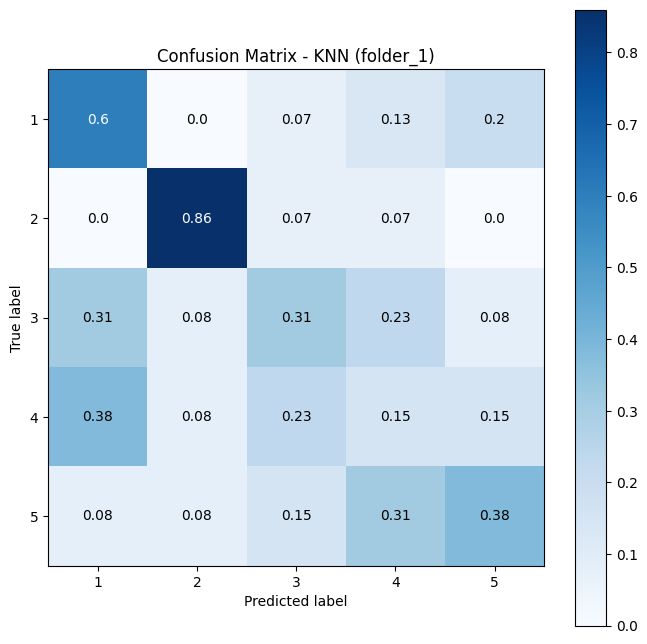

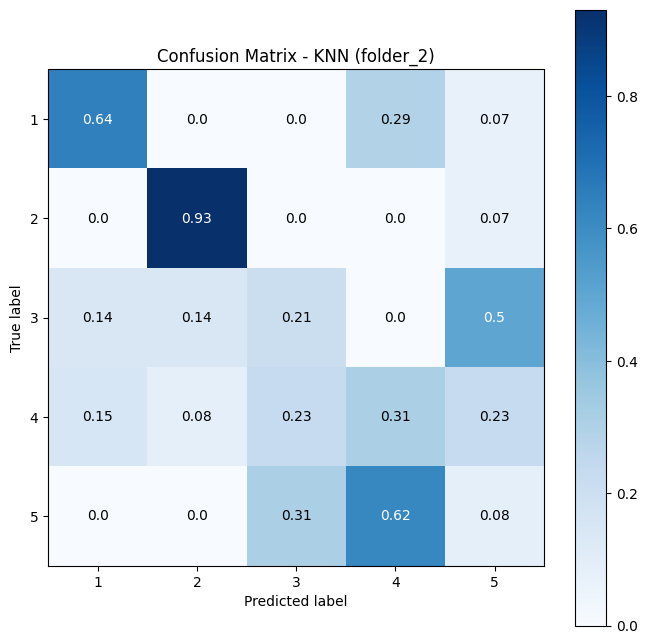

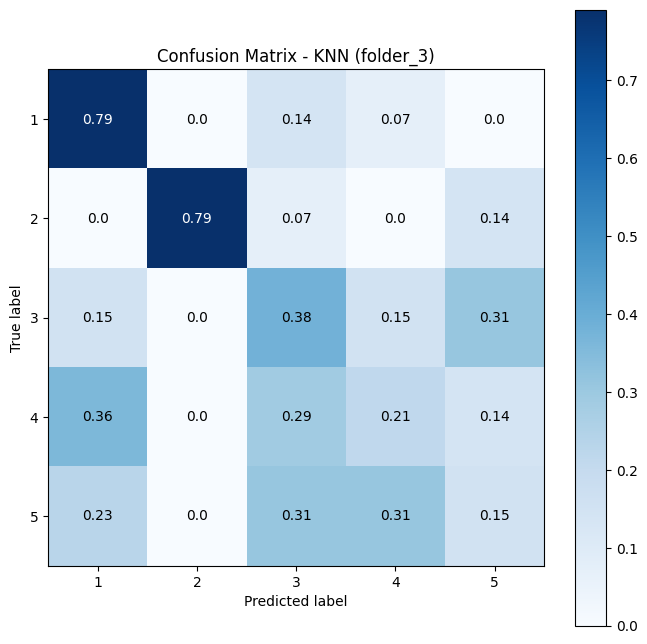

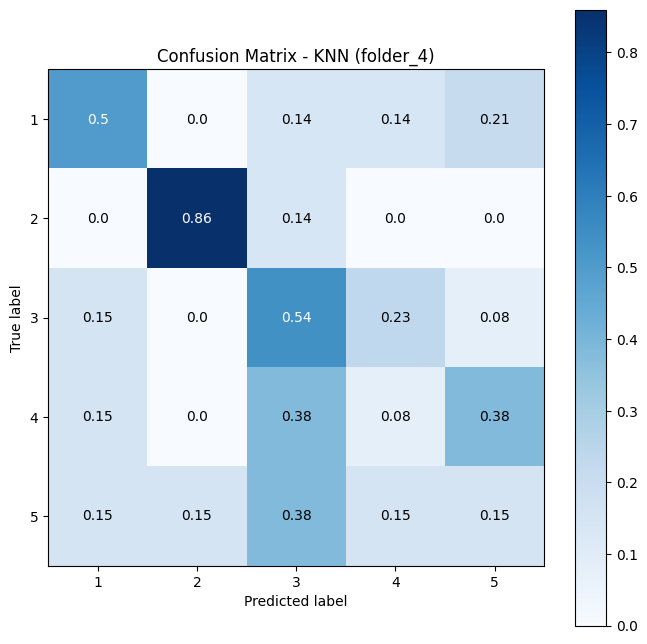

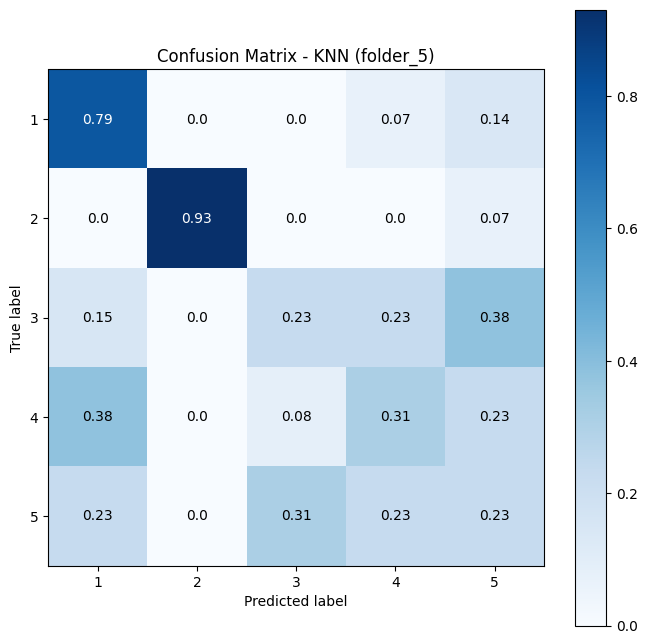

In [73]:
print(f'KNN:')
for folder in dados_cv_strat:       
    fig = plt.figure(figsize=(8,8))
    knn_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    Y_test = dados_cv_strat[folder]["teste"][1]
    Y_preds = knn_pipeline.predict(dados_cv_strat[folder]["teste"][0])
    ax = fig.add_subplot(111)
    
    skplt.metrics.plot_confusion_matrix(Y_test, Y_preds,
                                        normalize=True,
                                        title="Confusion Matrix - KNN (" + folder + ")",
                                        cmap="Blues",
                                        ax=ax
    );

NB:


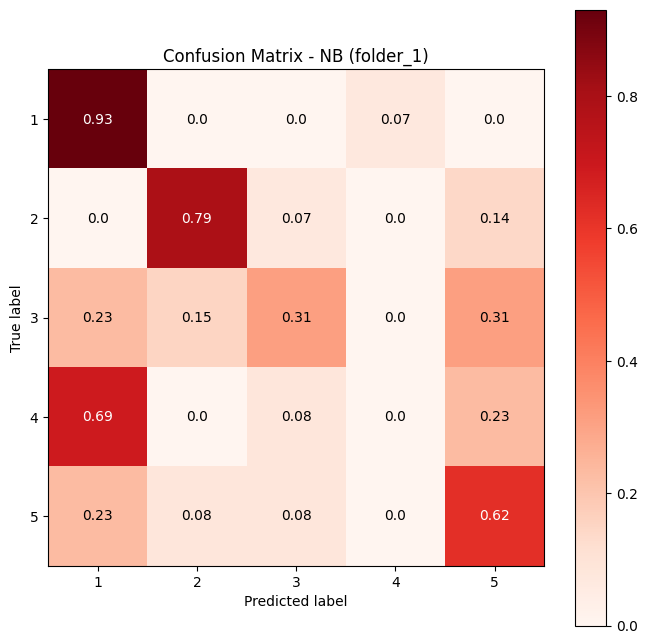

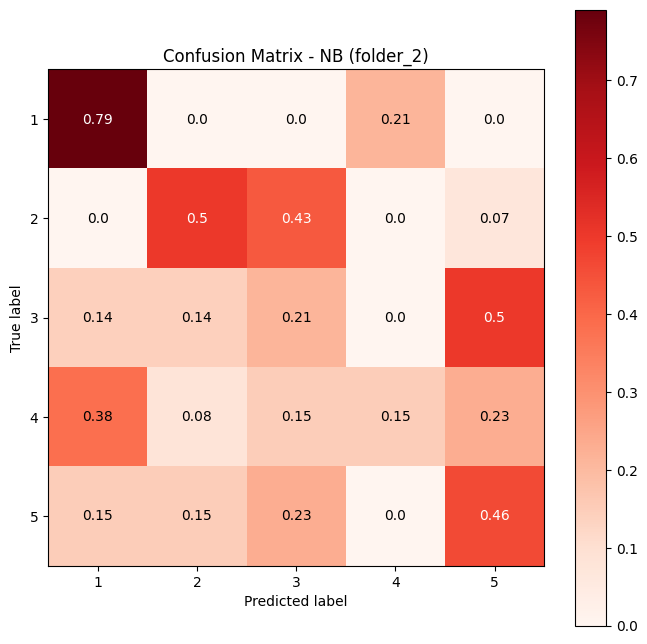

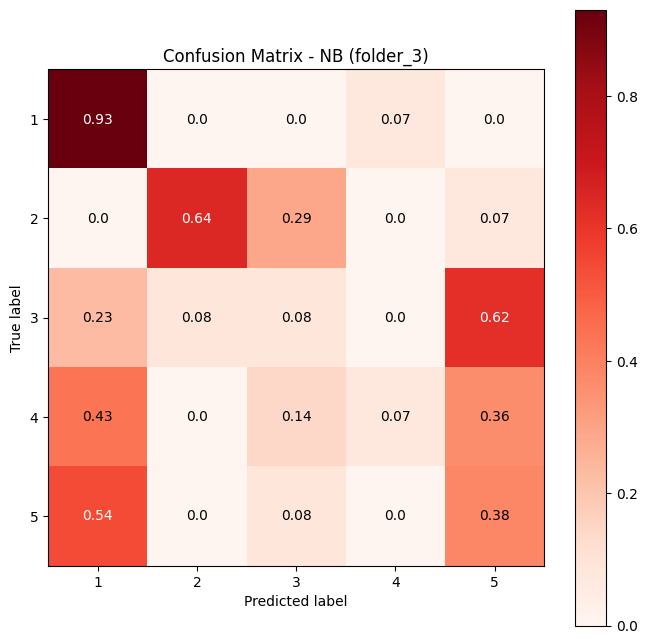

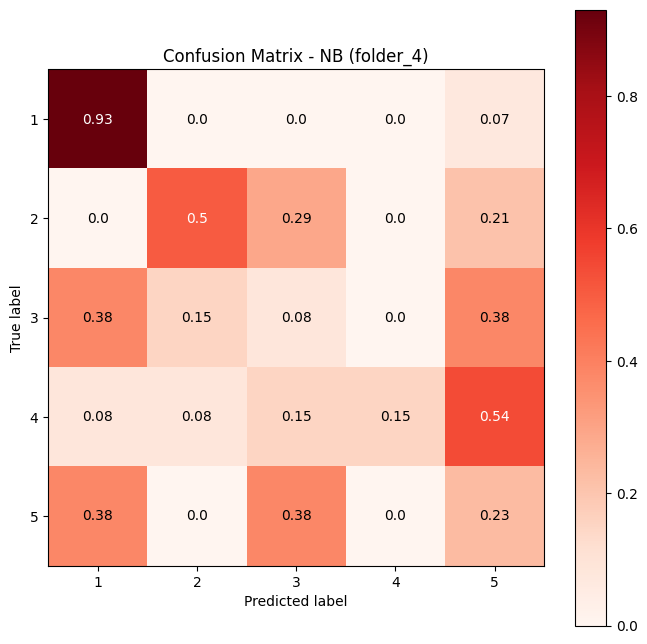

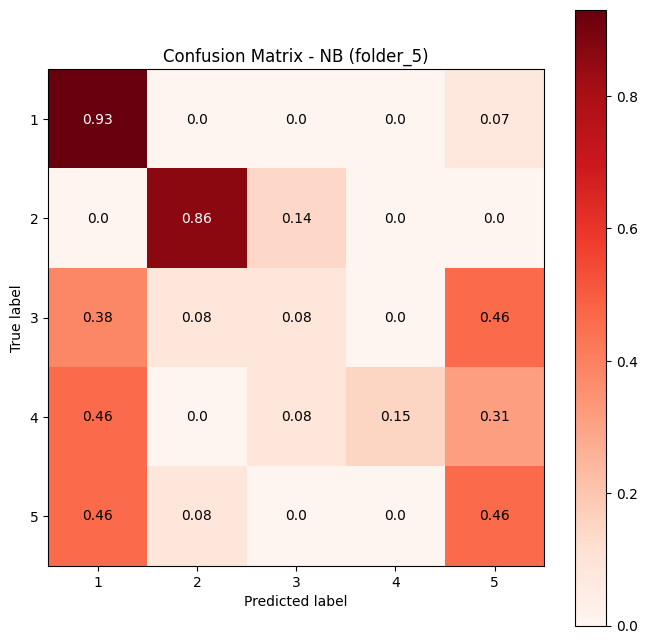

In [74]:
print(f'NB:')
for folder in dados_cv_strat:       
    fig = plt.figure(figsize=(8,8))
    nb_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    Y_test = dados_cv_strat[folder]["teste"][1]
    Y_preds = nb_pipeline.predict(dados_cv_strat[folder]["teste"][0])
    ax = fig.add_subplot(111)
    
    skplt.metrics.plot_confusion_matrix(Y_test, Y_preds,
                                        normalize=True,
                                        title="Confusion Matrix - NB (" + folder + ")",
                                        cmap="Reds",
                                        ax=ax
    );

DT:


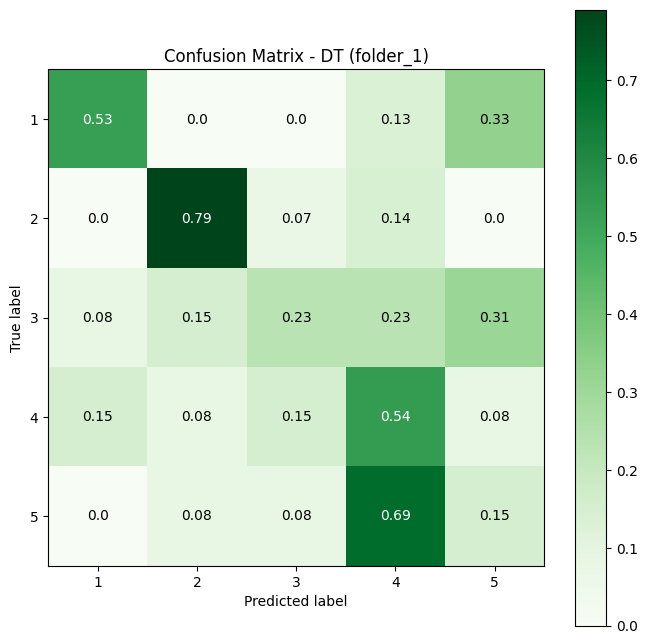

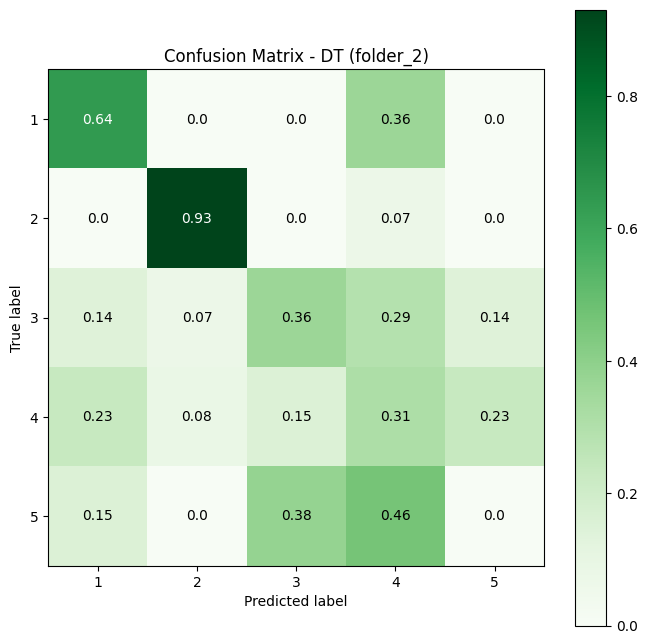

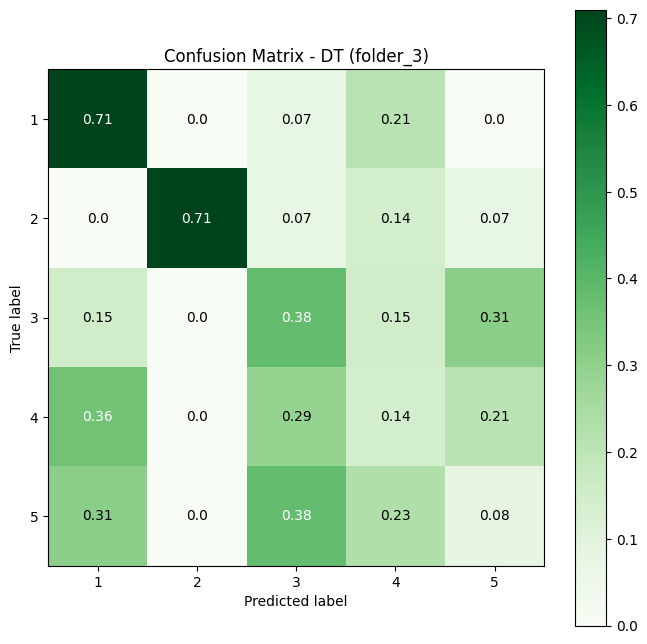

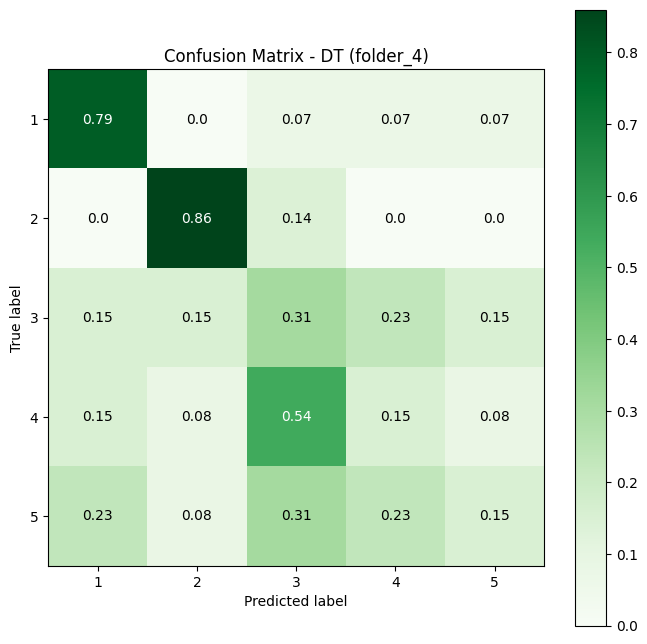

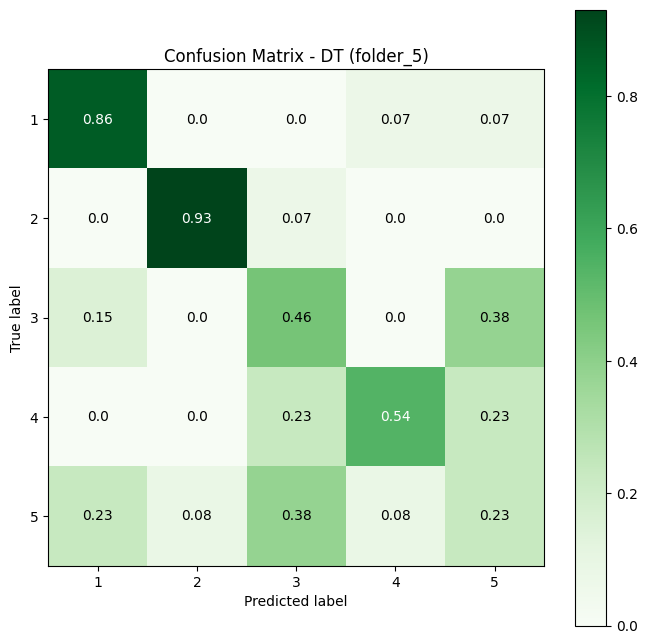

In [75]:
print(f'DT:')
for folder in dados_cv_strat:       
    fig = plt.figure(figsize=(8,8))
    dt_pipeline.fit(dados_cv_strat[folder]["treino"][0], dados_cv_strat[folder]["treino"][1])
    Y_test = dados_cv_strat[folder]["teste"][1]
    Y_preds = dt_pipeline.predict(dados_cv_strat[folder]["teste"][0])
    ax = fig.add_subplot(111)
    
    skplt.metrics.plot_confusion_matrix(Y_test, Y_preds,
                                        normalize=True,
                                        title="Confusion Matrix - DT (" + folder + ")",
                                        cmap="Greens",
                                        ax=ax
    ); 

#### Visualizando como cada modelo busca definir as fronteiras de separação das classes.

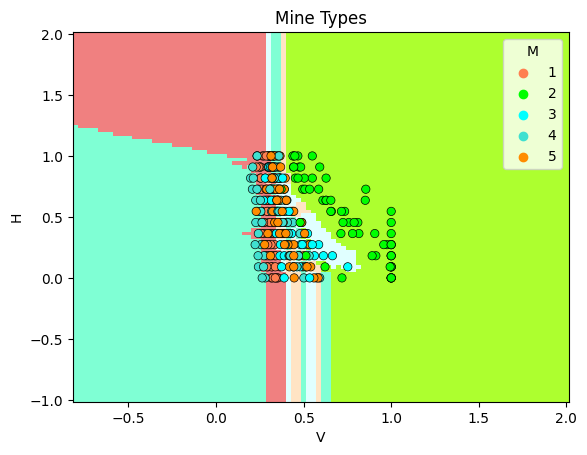

In [76]:
# Create color maps
n_neighbors=3
cmap_light = ListedColormap(['lightcoral', 'greenyellow', 'lightcyan', 'aquamarine', 'bisque'])
cmap_bold = ['coral', 'lime', 'cyan', 'turquoise', 'darkorange']

# {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}
clf = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=n_neighbors, weights='distance')
clf.fit(X, y)
_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap=cmap_light,
    ax=ax,
    response_method='predict',
    plot_method='pcolormesh',
    xlabel='V',
    ylabel='H',
    shading='auto',
)

# Plot 
sns.scatterplot(
    x=X.iloc[:,0],
    y=X.iloc[:,1],
    hue=mine['M'],
    palette=cmap_bold,
    alpha=1.0,
    edgecolor='black',
)

plt.title('Mine Types')

plt.show()

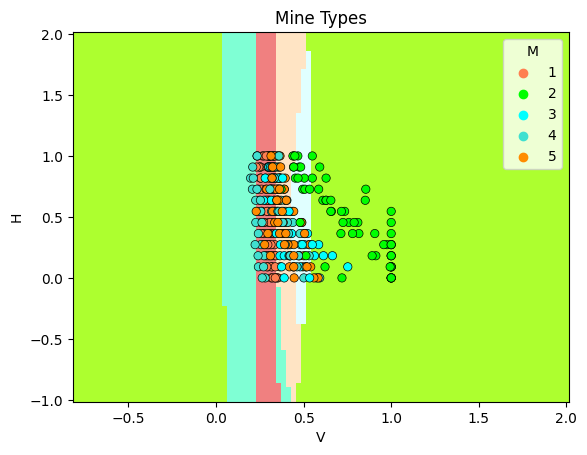

In [77]:
# Create color maps
cmap_light = ListedColormap(['lightcoral', 'greenyellow', 'lightcyan', 'aquamarine', 'bisque'])
cmap_bold = ['coral', 'lime', 'cyan', 'turquoise', 'darkorange']

# {'priors': None, 'var_smoothing': 0.0002310129700083158}
clf = GaussianNB(priors=None, var_smoothing=0.0002310129700083158)
clf.fit(X, y)
_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap=cmap_light,
    ax=ax,
    response_method='predict',
    plot_method='pcolormesh',
    xlabel='V',
    ylabel='H',
    shading='auto',
)

# Plot 
sns.scatterplot(
    x=X.iloc[:,0],
    y=X.iloc[:,1],
    hue=mine['M'],
    palette=cmap_bold,
    alpha=1.0,
    edgecolor='black',
)

plt.title('Mine Types')

plt.show()

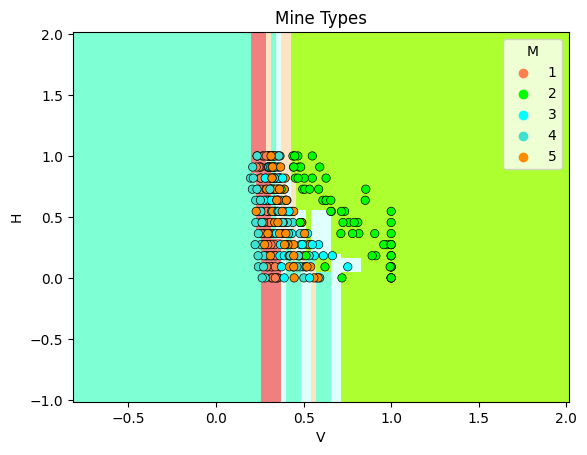

In [78]:
# Create color maps
cmap_light = ListedColormap(['lightcoral', 'greenyellow', 'lightcyan', 'aquamarine', 'bisque'])
cmap_bold = ['coral', 'lime', 'cyan', 'turquoise', 'darkorange']

# {'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'} 
clf = DecisionTreeClassifier(criterion='gini', max_depth=10, splitter= 'random')
clf.fit(X, y)
_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap=cmap_light,
    ax=ax,
    response_method='predict',
    plot_method='pcolormesh',
    xlabel='V',
    ylabel='H',
    shading='auto',
)

# Plot 
sns.scatterplot(
    x=X.iloc[:,0],
    y=X.iloc[:,1],
    hue=mine['M'],
    palette=cmap_bold,
    alpha=1.0,
    edgecolor='black',
)

plt.title('Mine Types')

plt.show()

### Conclusão

Para o primeiro conjunto de dados ('GLC' + 'precipitacao'), o modelo de Árvore de Decisão (_Decision Tree_) apresentou o melhor resultado, com acuária de 99,11% e desvio padrão de 0,17%, antes dos ajustes de parâmetros. As matrizes de confusão para as partições geradas pelo método `StratifiedKFold` mostram que, para a maioria das classes, o modelo apresentou muito pouco Falso-Negativos, com exceção da classe 'small', para a qual nenhum modelo conseguiu prever com eficiência. Ressalta-se que esse conjunto de dados encontra-se desbalanceado, com um número bem maior de registros da primeira classe ('medium').

Já no segundo conjunto de dados ('Land Mines'), os três modelos apresentaram desempenho mediano na tarefa de classificação, girando em torno de 45% a 47%. Mesmo com ajustes dos parâmetros dos modelos, o acréscimo no desempenho foi muito pequeno. No entando, a partir desses ajustes, os modelos passaram a "concordar" com a classificação para diferentes registros. 